### Notebook for the GO pathway enrichment analysis to distinguish pericytes from vSMC

- **Developed by:** Anna Maguza
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date:** 8th of January 2024

### Import required modules

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import anndata as ad

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import textwrap
from matplotlib.gridspec import GridSpec

### Set up working environment

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.4
scanpy      1.9.6
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
backcall                    0.2.0
brotli                      1.1.0
certifi                     2023.11.17
cffi                        1.16.0
charset_normalizer          3.3.2
colorama                    0.4.6
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.2.0
executing                   2.0.1
fastjsonschema              NA
fqdn                        NA
get_annotations             NA
h5py                        3.10.0
idna                        3.6
igraph                      0.11.3
importlib_resources         NA
ipykernel                   4.8.0
ipython_g

### Setup GO tools

In [4]:
#!mv /home/amaguza/data/gene_result.txt .
#!python /home/amaguza/miniforge3/envs/goatools_env/bin/ncbi_gene_results_to_python.py -o genes_ncbi_hum_proteincoding.py gene_result.txt

In [4]:
from genes_ncbi_hum_proteincoding import GENEID2NT as GeneID2nt_hum

In [5]:
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

In [6]:
#run one time to initialize
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms


In [7]:
#run one time to initialize
mapper = {}

for key in GeneID2nt_hum:
    mapper[GeneID2nt_hum[key].Symbol] = GeneID2nt_hum[key].GeneID
    
inv_map = {v: k for k, v in mapper.items()}

In [8]:
#run one time to initialize

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])
# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

HMS:0:00:35.593695 345,219 annotations, 20,760 genes, 18,774 GOs, 1 taxids READ: gene2go 


In [9]:
#run one time to initialize
goeaobj = GOEnrichmentStudyNS(
            GeneID2nt_hum.keys(),  # List of human protein-coding genes
            ns2assoc,  # geneID/GO associations
            obodag,  # Ontologies
            propagate_counts=False,
            alpha=0.05,  # default significance cut-off
            methods=['fdr_bh'])  # default multipletest correction method


Load BP Ontology Enrichment Analysis ...
 83% 17,011 of 20,606 population items found in association

Load CC Ontology Enrichment Analysis ...
 88% 18,138 of 20,606 population items found in association

Load MF Ontology Enrichment Analysis ...
 85% 17,592 of 20,606 population items found in association


In [10]:
#run one time to initialize
GO_items = []

temp = goeaobj.ns2objgoea['BP'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['CC'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['MF'].assoc
for item in temp:
    GO_items += temp[item]

In [11]:
#pass list of gene symbols
def go_it(test_genes):
    print(f'input genes: {len(test_genes)}')
    
    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            pass
    print(f'mapped genes: {len(mapped_genes)}')
    
    goea_results_all = goeaobj.run_study(mapped_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    GO = pd.DataFrame(list(map(lambda x: [x.GO, x.goterm.name, x.goterm.namespace, x.p_uncorrected, x.p_fdr_bh,\
                   x.ratio_in_study[0], x.ratio_in_study[1], GO_items.count(x.GO), list(map(lambda y: inv_map[y], x.study_items)),\
                   ], goea_results_sig)), columns = ['GO', 'term', 'class', 'p', 'p_corr', 'n_genes',\
                                                    'n_study', 'n_go', 'study_genes'])

    GO = GO[GO.n_genes > 1]
    return GO

### Read in Human skin dataset

In [12]:
adata= sc.read_h5ad('data_skin/SCC0120_1_Skin_scANVI_leiden_Anna.h5ad') 
adata

AnnData object with n_obs × n_vars = 7479 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'skin_condition', 'cell_type', 'leiden'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0

### Extract DEGs

* Normalize and log transform

In [13]:
adata_log = ad.AnnData(X = adata.X,  var = adata.var, obs = adata.obs, obsm = adata.obsm)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)
adata_log.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(adata_log, inplace = False)["X"]
)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


* Identify differentially expressed genes

In [14]:
sc.tl.rank_genes_groups(adata_log, groupby="leiden", method="wilcoxon")
df = sc.get.rank_genes_groups_df(adata_log, group=None)

ranking genes


/home/amaguza/miniforge3/envs/goatools_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


/home/amaguza/miniforge3/envs/goatools_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/amaguza/miniforge3/envs/goatools_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/amaguza/miniforge3/envs/goatools_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_g

In [15]:
df_filtered = df[(df.pvals_adj < 0.05) & (df.logfoldchanges > 1.5)]

* Extract DEGs for cluster 0

In [16]:
df_0 = df_filtered[df_filtered['group'] == '0']

In [17]:
df_0.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,MUSTN1,42.006504,7.935400,0.000000e+00,0.000000e+00
1,0,TPM2,38.086582,6.727271,0.000000e+00,0.000000e+00
2,0,MYH11,36.420456,6.771474,2.020338e-290,1.848542e-286
3,0,MYL9,36.369740,5.872153,1.281271e-289,8.792403e-286
4,0,RERGL,36.009678,8.962753,5.902689e-284,3.240458e-280


In [18]:
go_df = go_it(df_0.names.values)

input genes: 1175
mapped genes: 1094

Runing BP Ontology Analysis: current study set of 1094 IDs.
 93%  1,021 of  1,094 study items found in association
100%  1,094 of  1,094 study items found in population(20606)
Calculating 12,220 uncorrected p-values using fisher_scipy_stats
  12,220 terms are associated with 17,011 of 20,606 population items
   3,905 terms are associated with  1,021 of  1,094 study items
  METHOD fdr_bh:
      64 GO terms found significant (< 0.05=alpha) ( 63 enriched +   1 purified): statsmodels fdr_bh
     516 study items associated with significant GO IDs (enriched)
       1 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 1094 IDs.
 97%  1,061 of  1,094 study items found in association
100%  1,094 of  1,094 study items found in population(20606)
Calculating 1,800 uncorrected p-values using fisher_scipy_stats
   1,800 terms are associated with 18,138 of 20,606 population items
     676 terms are associa

In [19]:
go_df0 = go_df[0:10]

In [33]:
go_df0.head()

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes
0,GO:0002181,cytoplasmic translation,biological_process,5.753574e-19,7.030867e-15,32,1094,89,"[RPL10A, RPL22, RPL23A, RPL23, RPL24, RPL27, R..."
1,GO:0042776,proton motive force-driven mitochondrial ATP s...,biological_process,3.589511e-16,2.193191e-12,25,1094,64,"[ATP5F1D, NDUFA13, ATP5MG, ATP5ME, ATP5PF, NDU..."
2,GO:0006412,translation,biological_process,1.432502e-13,5.835057e-10,37,1094,181,"[RPL10A, RPL22, RPL23A, RPL23, RPL24, RPL27, R..."
3,GO:0045333,cellular respiration,biological_process,3.651606e-13,1.115566e-09,18,1094,41,"[COX6C, CYC1, COX7A2, UQCR10, COX7B, COX7C, CO..."
4,GO:0009060,aerobic respiration,biological_process,1.258613e-11,3.076050e-08,21,1094,66,"[ATP5F1D, NDUFA13, NDUFB11, NDUFA11, UQCRB, ND..."


<ipython-input-20-f2a9ad4c9e86>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=go_df0, x='p', y='term', palette=mapper1.to_rgba(go_df0.p_corr.values), ax=ax1)
<ipython-input-20-f2a9ad4c9e86>:13: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=go_df0, x='p', y='term', palette=mapper1.to_rgba(go_df0.p_corr.values), ax=ax1)
<ipython-input-20-f2a9ad4c9e86>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df0['term']])


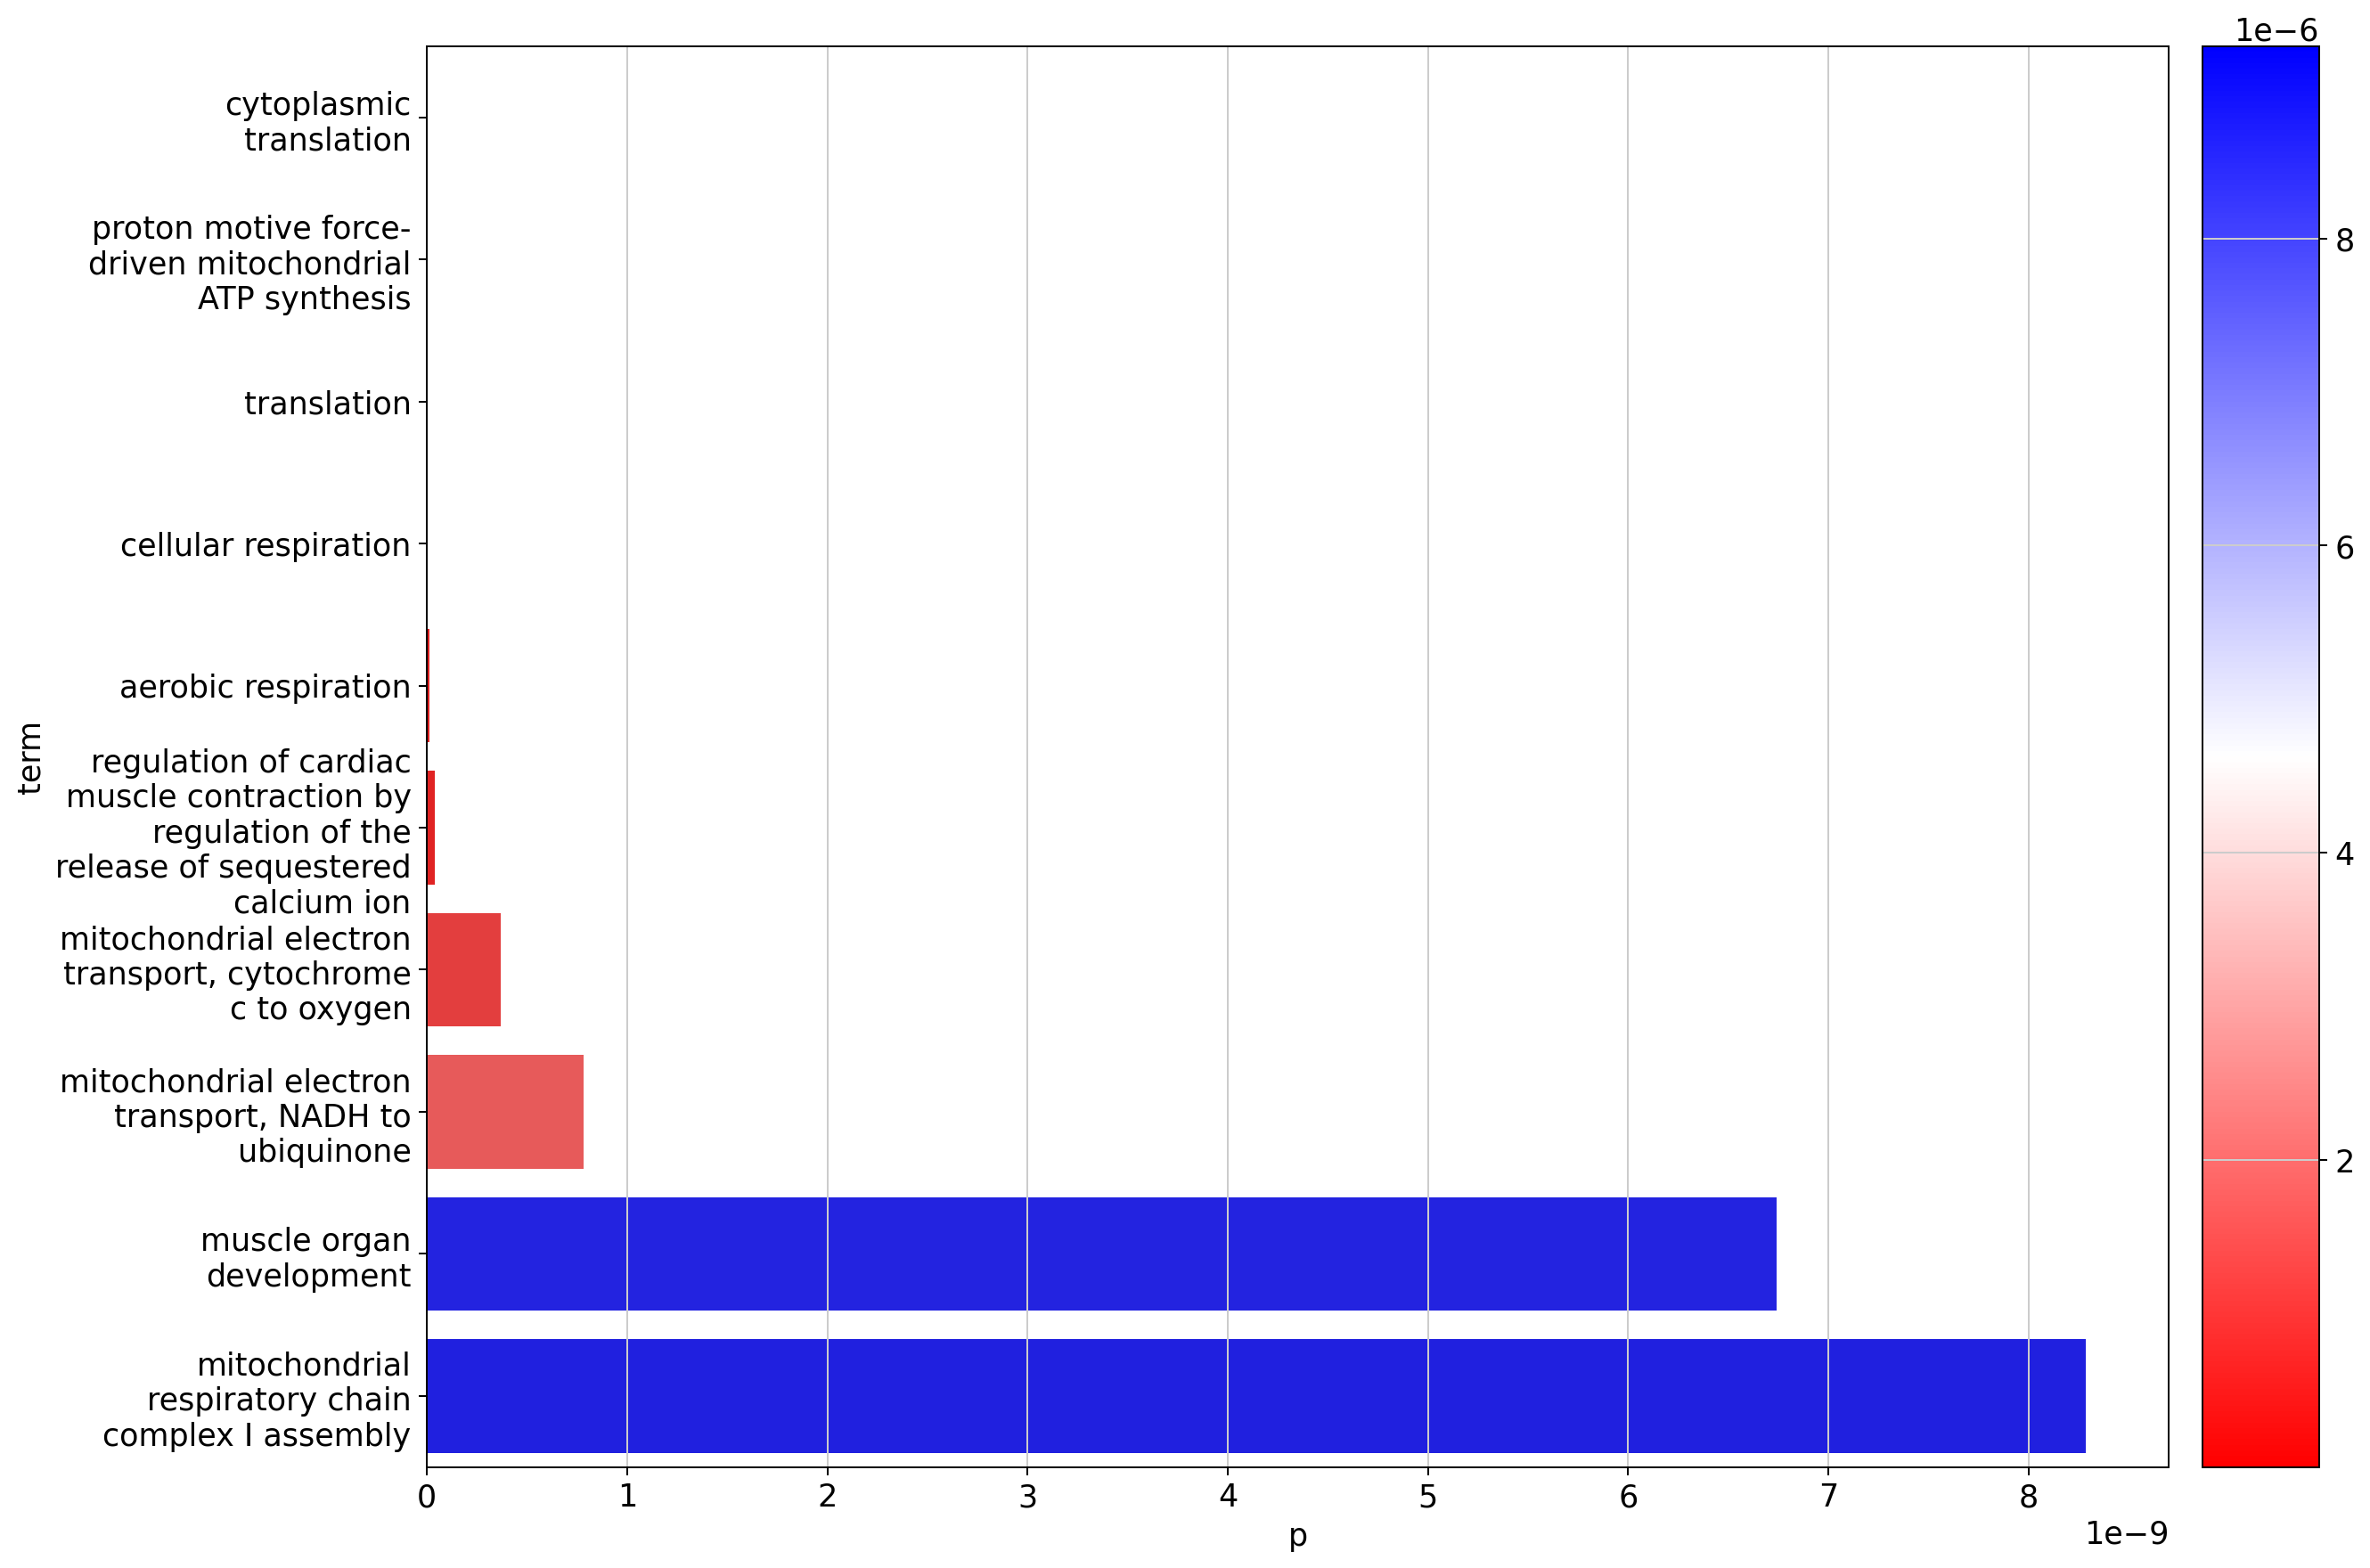

In [20]:
cmap = mpl.cm.bwr_r
norm = mpl.colors.Normalize(vmin = go_df0.p_corr.min(), vmax = go_df0.p_corr.max())
mapper1 = cm.ScalarMappable(norm = norm, cmap = cm.bwr_r)

# Create a 1x2 grid
fig = plt.figure(figsize=(15, 10))

# Define the grid layout
gs = GridSpec(1, 2, width_ratios=[15, 1])

# Left plot
ax1 = plt.subplot(gs[0])
sns.barplot(data=go_df0, x='p', y='term', palette=mapper1.to_rgba(go_df0.p_corr.values), ax=ax1)
ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df0['term']])


# Right plot (Colorbar)
ax2 = plt.subplot(gs[1])
cbl = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')


plt.tight_layout()  # Adjust layout for better spacing
plt.show()

* Cluster 1

In [21]:
df_1 = df_filtered[df_filtered['group'] == '1']

In [22]:
go_df = go_it(df_1.names.values)

input genes: 691
mapped genes: 640

Runing BP Ontology Analysis: current study set of 640 IDs.
 95%    610 of    640 study items found in association
100%    640 of    640 study items found in population(20606)
Calculating 12,220 uncorrected p-values using fisher_scipy_stats
  12,220 terms are associated with 17,011 of 20,606 population items
   3,232 terms are associated with    610 of    640 study items
  METHOD fdr_bh:
     108 GO terms found significant (< 0.05=alpha) (107 enriched +   1 purified): statsmodels fdr_bh
     393 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 640 IDs.
 99%    632 of    640 study items found in association
100%    640 of    640 study items found in population(20606)
Calculating 1,800 uncorrected p-values using fisher_scipy_stats
   1,800 terms are associated with 18,138 of 20,606 population items
     449 terms are associated 

In [23]:
go_df1 = go_df[0:10]

<ipython-input-24-ce5bbf3ede96>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=go_df1, x='p_corr', y='term', palette=mapper1.to_rgba(go_df1.p_corr.values), ax=ax1)
<ipython-input-24-ce5bbf3ede96>:9: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=go_df1, x='p_corr', y='term', palette=mapper1.to_rgba(go_df1.p_corr.values), ax=ax1)
<ipython-input-24-ce5bbf3ede96>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df1['term']])


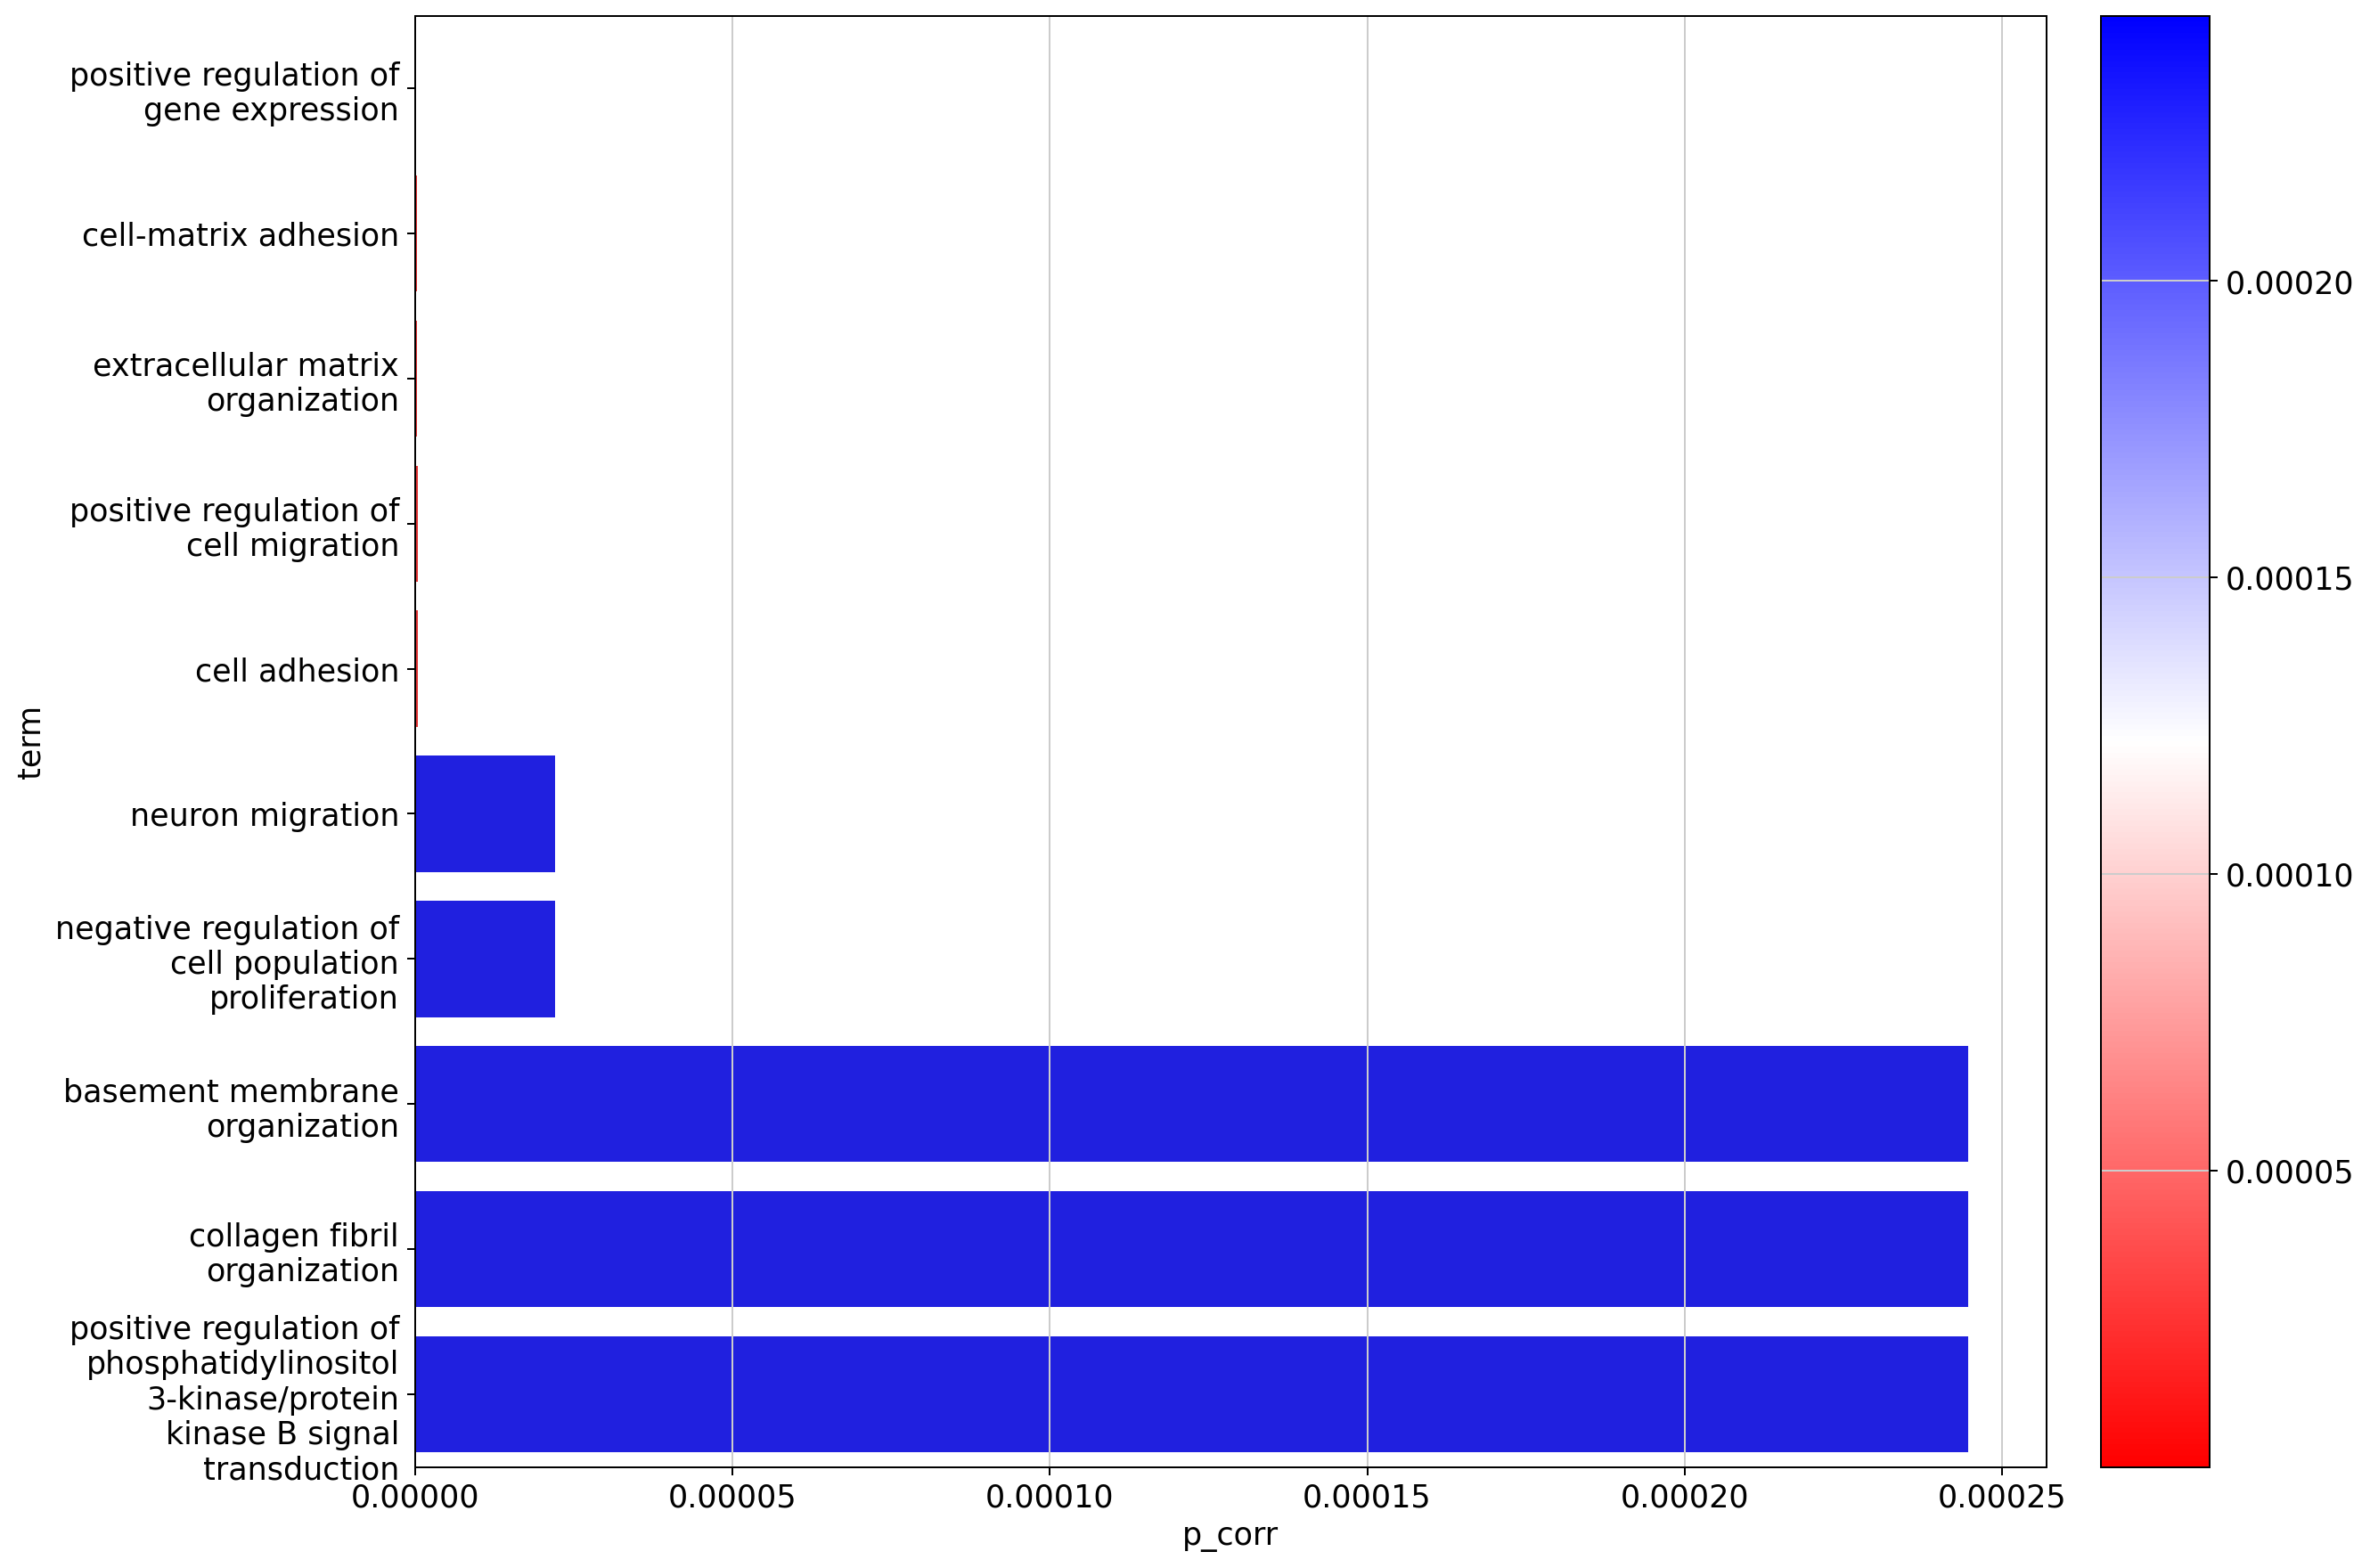

In [24]:
# Create a 1x2 grid
fig = plt.figure(figsize=(15, 10))

# Define the grid layout
gs = GridSpec(1, 2, width_ratios=[15, 1])

# Left plot
ax1 = plt.subplot(gs[0])
sns.barplot(data=go_df1, x='p_corr', y='term', palette=mapper1.to_rgba(go_df1.p_corr.values), ax=ax1)
ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df1['term']])


# Right plot (Colorbar)
ax2 = plt.subplot(gs[1])
cmap = mpl.cm.bwr_r
norm = mpl.colors.Normalize(vmin=go_df1.p_corr.min(), vmax=go_df1.p_corr.max())
mapper1 = cm.ScalarMappable(norm=norm, cmap=cm.bwr_r)
cbl = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')


plt.tight_layout()  # Adjust layout for better spacing
plt.show()

* Cluster 10

In [25]:
df_10 = df_filtered[df_filtered['group'] == '10']

In [51]:
go_df = go_it(df_10.names.values)

input genes: 556
mapped genes: 514

Runing BP Ontology Analysis: current study set of 514 IDs.
 93%    477 of    514 study items found in association
100%    514 of    514 study items found in population(20606)
Calculating 12,220 uncorrected p-values using fisher_scipy_stats
  12,220 terms are associated with 17,011 of 20,606 population items
   2,654 terms are associated with    477 of    514 study items
  METHOD fdr_bh:
      73 GO terms found significant (< 0.05=alpha) ( 72 enriched +   1 purified): statsmodels fdr_bh
     290 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 514 IDs.
 97%    500 of    514 study items found in association
100%    514 of    514 study items found in population(20606)
Calculating 1,800 uncorrected p-values using fisher_scipy_stats
   1,800 terms are associated with 18,138 of 20,606 population items
     456 terms are associated 

In [52]:
go_df10 = go_df[0:10]

<ipython-input-54-6a521aaa669f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper.to_rgba(go_df10.p_corr.values), ax=ax1)
<ipython-input-54-6a521aaa669f>:9: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper.to_rgba(go_df10.p_corr.values), ax=ax1)
<ipython-input-54-6a521aaa669f>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df10['term']])


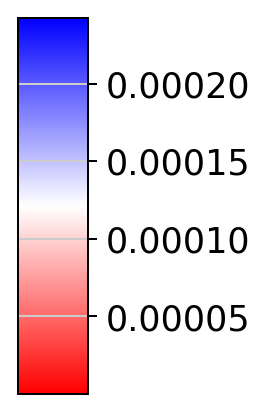

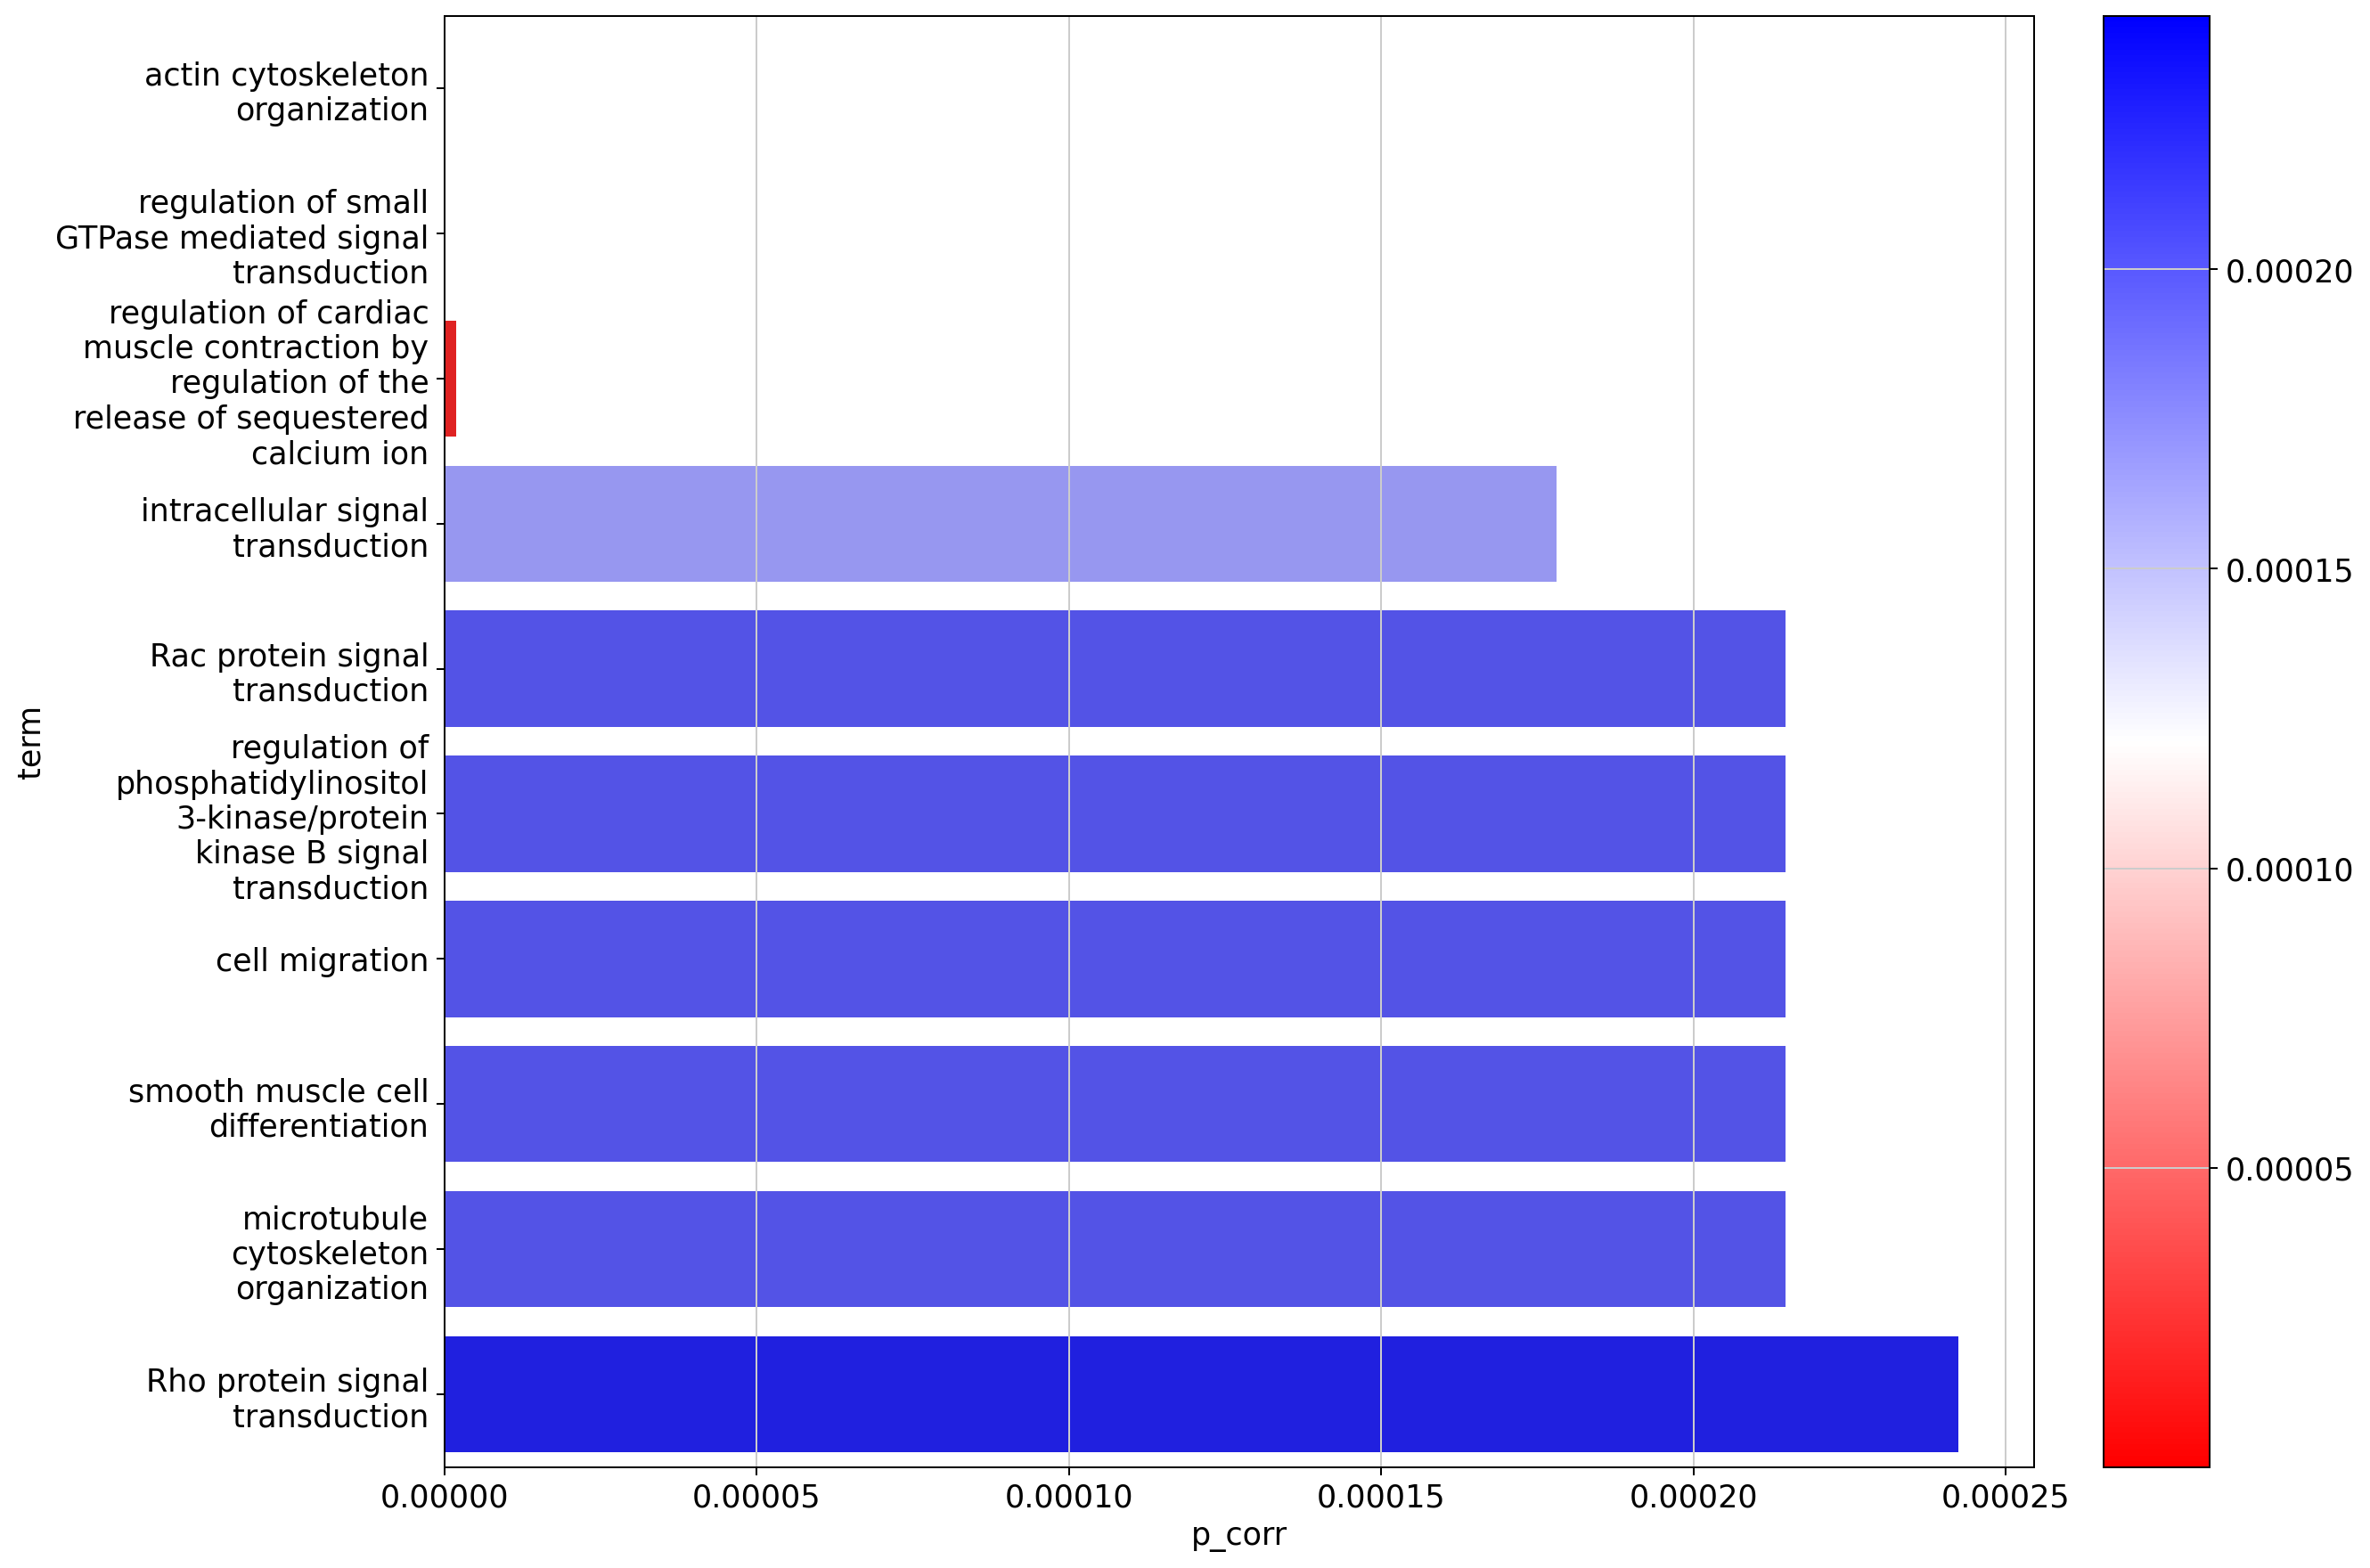

In [54]:
# Create a 1x2 grid
fig = plt.figure(figsize=(15, 10))

# Define the grid layout
gs = GridSpec(1, 2, width_ratios=[15, 1])

# Left plot
ax1 = plt.subplot(gs[0])
sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper1.to_rgba(go_df10.p_corr.values), ax=ax1)
ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df10['term']])


# Right plot (Colorbar)
ax2 = plt.subplot(gs[1])
cmap = mpl.cm.bwr_r
norm = mpl.colors.Normalize(vmin=go_df10.p_corr.min(), vmax=go_df10.p_corr.max())
mapper1 = cm.ScalarMappable(norm=norm, cmap=cm.bwr_r)
cbl = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')


plt.tight_layout()  # Adjust layout for better spacing
plt.show()

* Cluster 7

In [62]:
df_10 = df_filtered[df_filtered['group'] == '7']

In [64]:
go_df = go_it(df_10.names.values)

input genes: 714
mapped genes: 658

Runing BP Ontology Analysis: current study set of 658 IDs.
 95%    623 of    658 study items found in association
100%    658 of    658 study items found in population(20606)
Calculating 12,220 uncorrected p-values using fisher_scipy_stats
  12,220 terms are associated with 17,011 of 20,606 population items
   3,097 terms are associated with    623 of    658 study items
  METHOD fdr_bh:
      92 GO terms found significant (< 0.05=alpha) ( 91 enriched +   1 purified): statsmodels fdr_bh
     393 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 658 IDs.
 99%    649 of    658 study items found in association
100%    658 of    658 study items found in population(20606)
Calculating 1,800 uncorrected p-values using fisher_scipy_stats
   1,800 terms are associated with 18,138 of 20,606 population items
     465 terms are associated 

In [65]:
go_df10 = go_df[0:10]

<ipython-input-67-6a521aaa669f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper.to_rgba(go_df10.p_corr.values), ax=ax1)
<ipython-input-67-6a521aaa669f>:9: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper.to_rgba(go_df10.p_corr.values), ax=ax1)
<ipython-input-67-6a521aaa669f>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df10['term']])


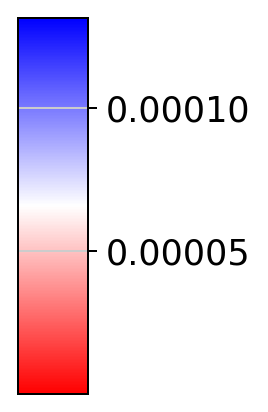

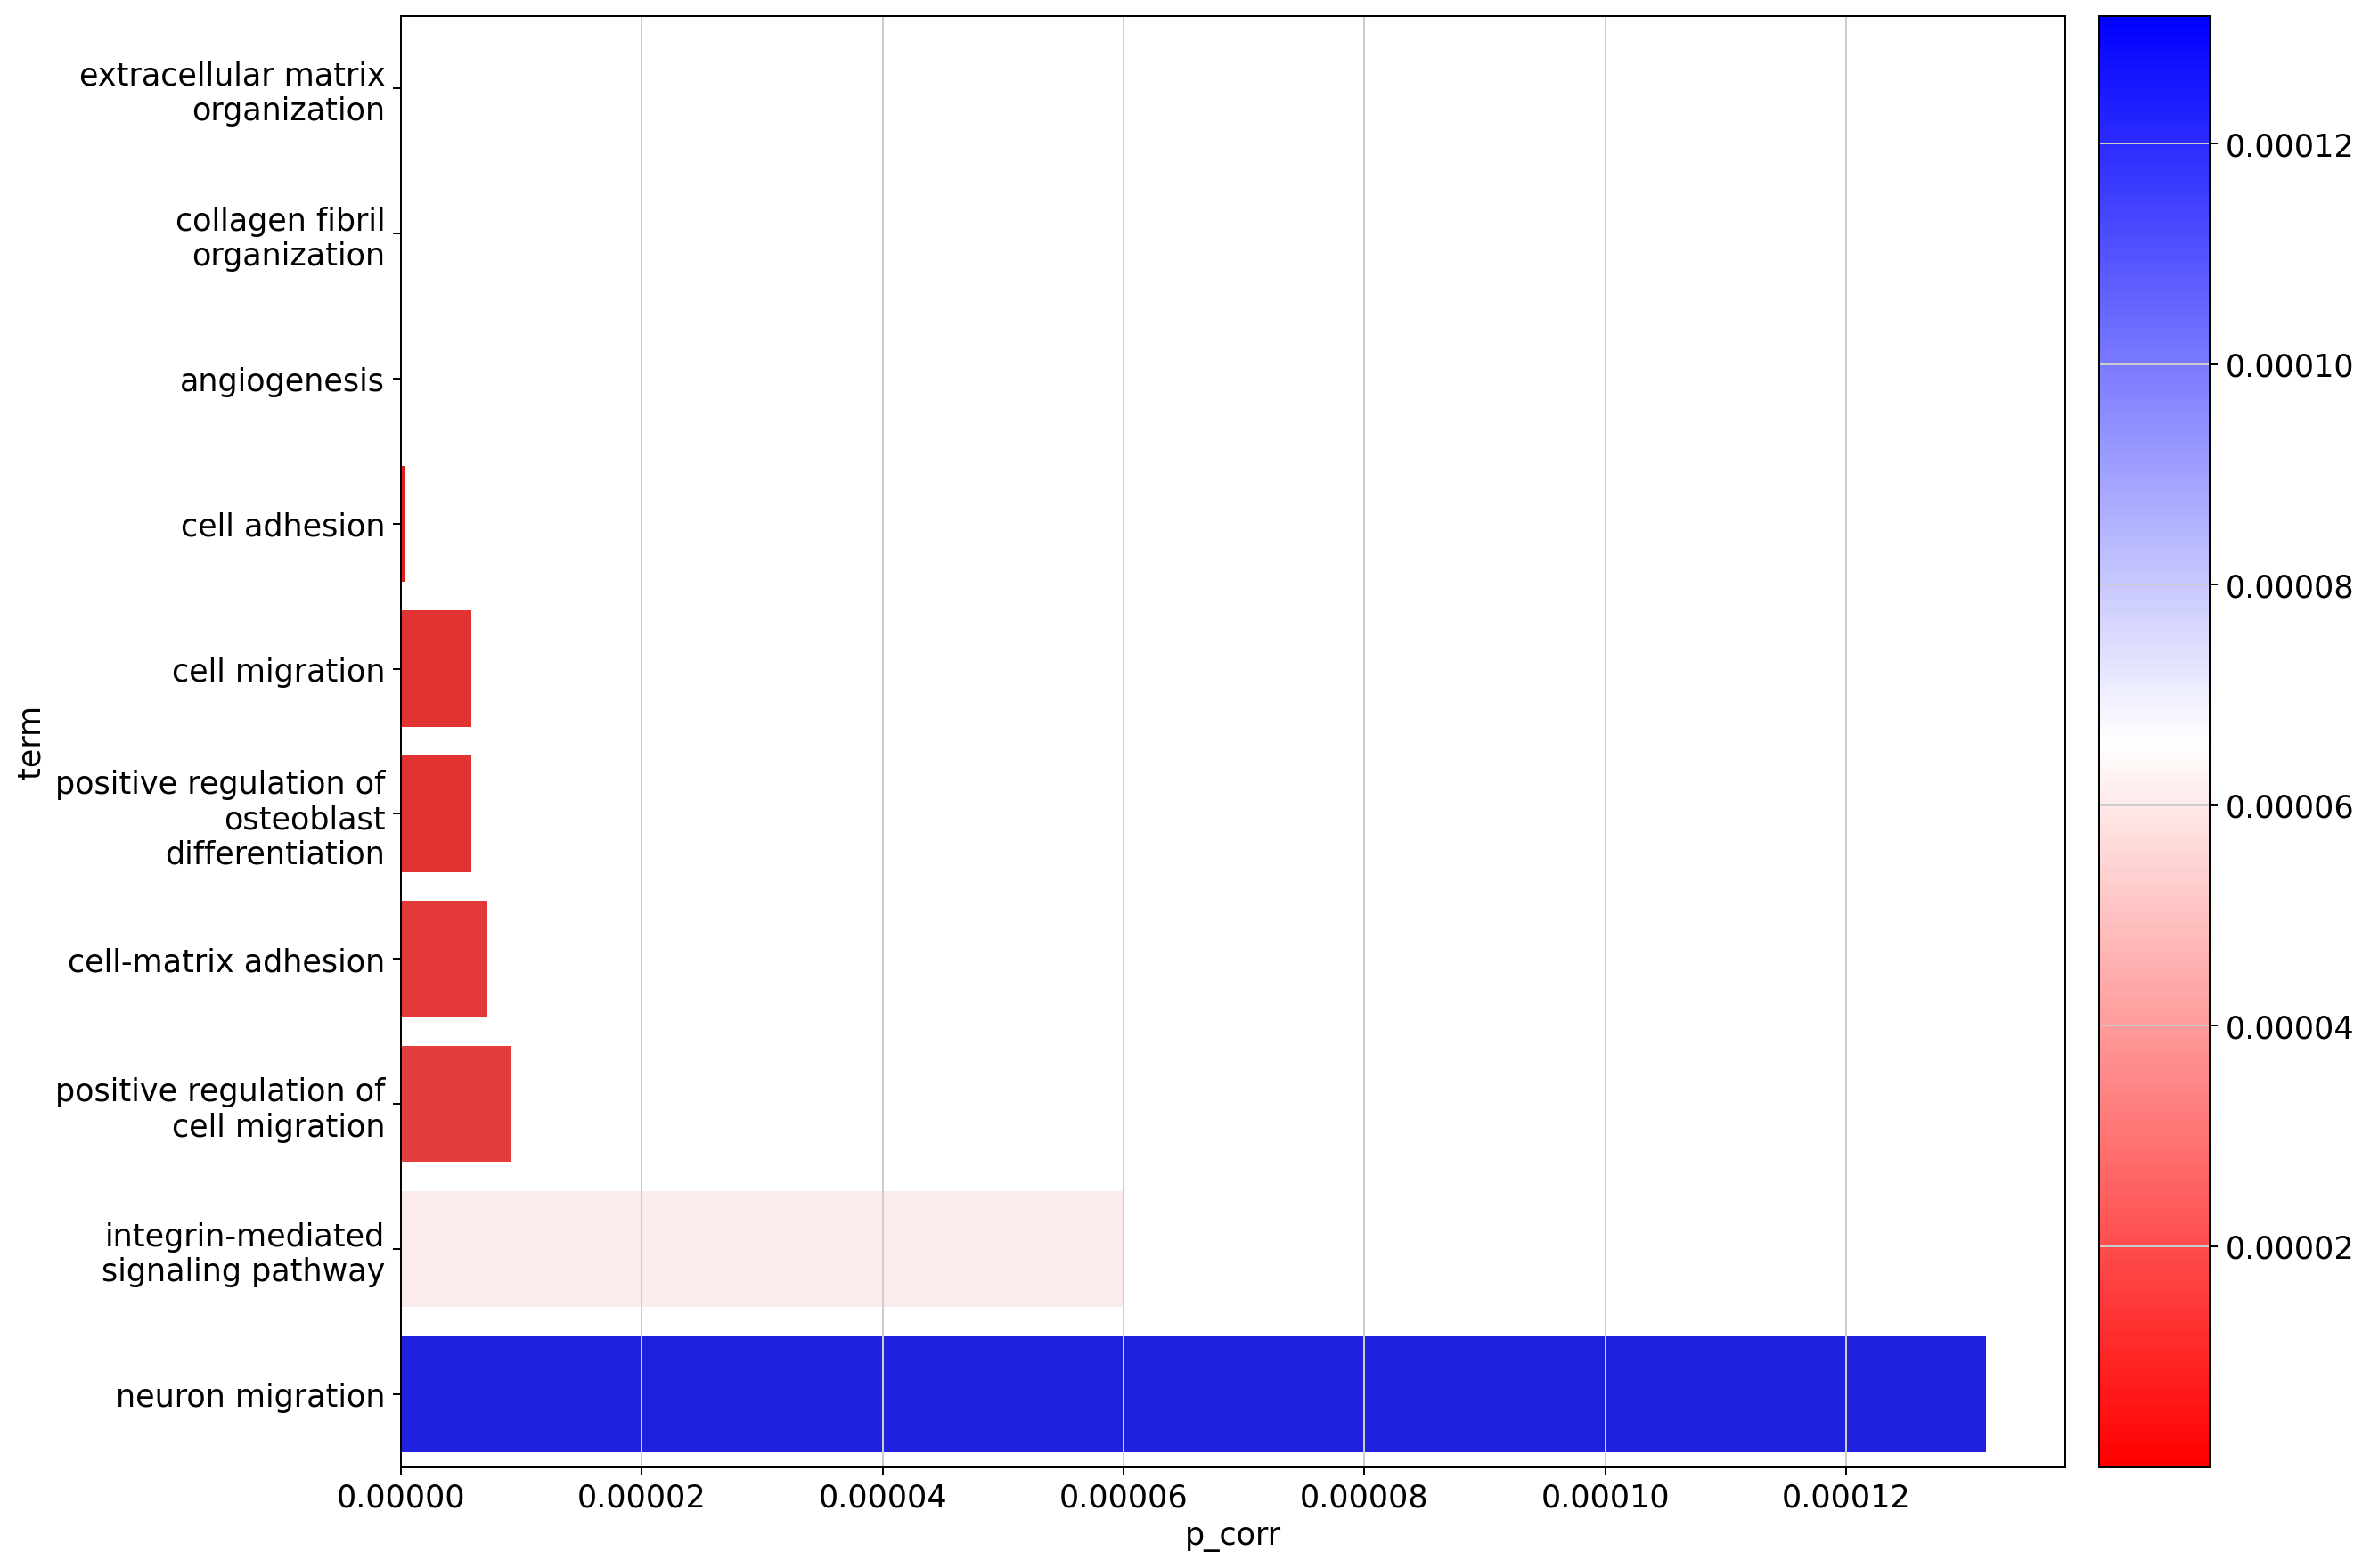

In [67]:
# Create a 1x2 grid
fig = plt.figure(figsize=(15, 10))

# Define the grid layout
gs = GridSpec(1, 2, width_ratios=[15, 1])

# Left plot
ax1 = plt.subplot(gs[0])
sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper1.to_rgba(go_df10.p_corr.values), ax=ax1)
ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df10['term']])


# Right plot (Colorbar)
ax2 = plt.subplot(gs[1])
cmap = mpl.cm.bwr_r
norm = mpl.colors.Normalize(vmin=go_df10.p_corr.min(), vmax=go_df10.p_corr.max())
mapper1 = cm.ScalarMappable(norm=norm, cmap=cm.bwr_r)
cbl = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')


plt.tight_layout()  # Adjust layout for better spacing
plt.show()

* Cluster 8

input genes: 772
mapped genes: 712

Runing BP Ontology Analysis: current study set of 712 IDs.
 94%    669 of    712 study items found in association
100%    712 of    712 study items found in population(20606)
Calculating 12,220 uncorrected p-values using fisher_scipy_stats
  12,220 terms are associated with 17,011 of 20,606 population items
   3,328 terms are associated with    669 of    712 study items
  METHOD fdr_bh:
      98 GO terms found significant (< 0.05=alpha) ( 97 enriched +   1 purified): statsmodels fdr_bh
     410 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 712 IDs.
 98%    696 of    712 study items found in association
100%    712 of    712 study items found in population(20606)
Calculating 1,800 uncorrected p-values using fisher_scipy_stats
   1,800 terms are associated with 18,138 of 20,606 population items
     485 terms are associated 

<ipython-input-26-218aa3aafebc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper1.to_rgba(go_df10.p_corr.values), ax=ax1)
<ipython-input-26-218aa3aafebc>:13: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper1.to_rgba(go_df10.p_corr.values), ax=ax1)
<ipython-input-26-218aa3aafebc>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df10['term']])


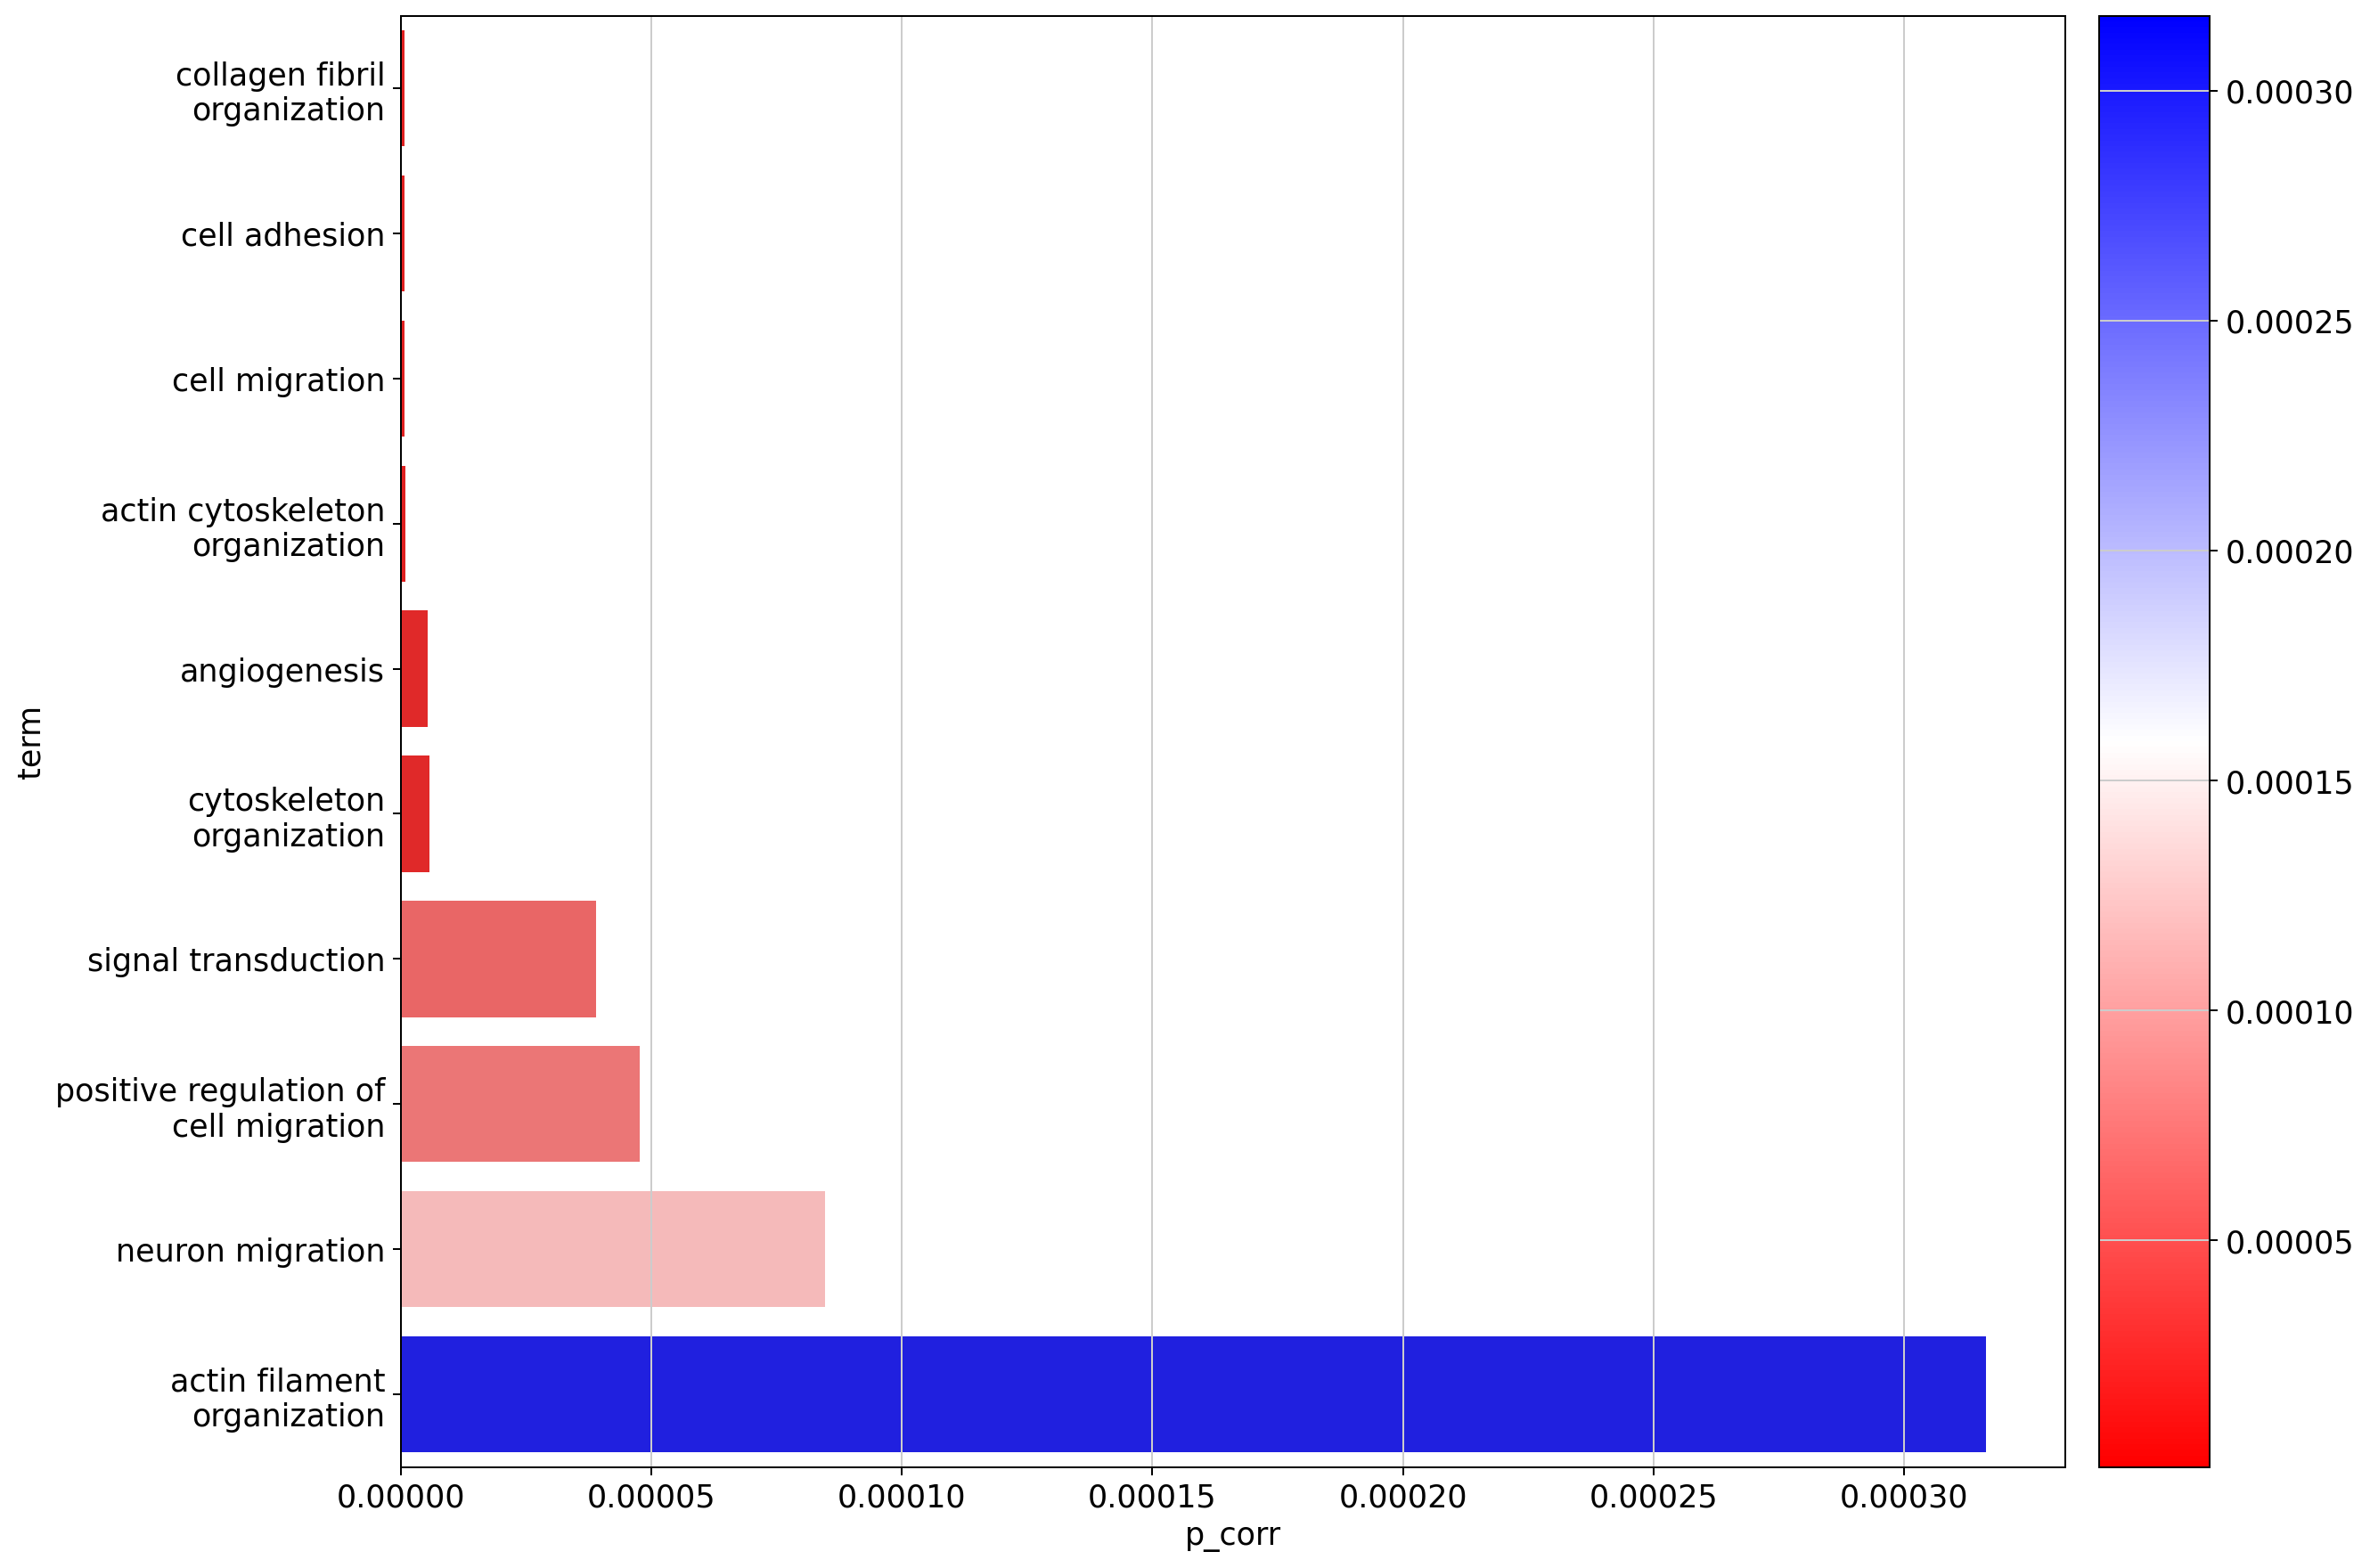

In [26]:
df_10 = df_filtered[df_filtered['group'] == '8']
go_df = go_it(df_10.names.values)
go_df10 = go_df[0:10]

# Create a 1x2 grid
fig = plt.figure(figsize=(15, 10))

# Define the grid layout
gs = GridSpec(1, 2, width_ratios=[15, 1])

# Left plot
ax1 = plt.subplot(gs[0])
sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper1.to_rgba(go_df10.p_corr.values), ax=ax1)
ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df10['term']])


# Right plot (Colorbar)
ax2 = plt.subplot(gs[1])
cmap = mpl.cm.bwr_r
norm = mpl.colors.Normalize(vmin=go_df10.p_corr.min(), vmax=go_df10.p_corr.max())
mapper1 = cm.ScalarMappable(norm=norm, cmap=cm.bwr_r)
cbl = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')


plt.tight_layout()  # Adjust layout for better spacing
plt.show()

* Cluster 18

input genes: 369
mapped genes: 356

Runing BP Ontology Analysis: current study set of 356 IDs.
 96%    340 of    356 study items found in association
100%    356 of    356 study items found in population(20606)
Calculating 12,220 uncorrected p-values using fisher_scipy_stats
  12,220 terms are associated with 17,011 of 20,606 population items
   2,161 terms are associated with    340 of    356 study items
  METHOD fdr_bh:
      69 GO terms found significant (< 0.05=alpha) ( 69 enriched +   0 purified): statsmodels fdr_bh
     219 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 356 IDs.
 99%    353 of    356 study items found in association
100%    356 of    356 study items found in population(20606)
Calculating 1,800 uncorrected p-values using fisher_scipy_stats
   1,800 terms are associated with 18,138 of 20,606 population items
     362 terms are associated 

<ipython-input-27-5b3ec46a9467>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper1.to_rgba(go_df10.p_corr.values), ax=ax1)
<ipython-input-27-5b3ec46a9467>:14: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper1.to_rgba(go_df10.p_corr.values), ax=ax1)
<ipython-input-27-5b3ec46a9467>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df10['term']])


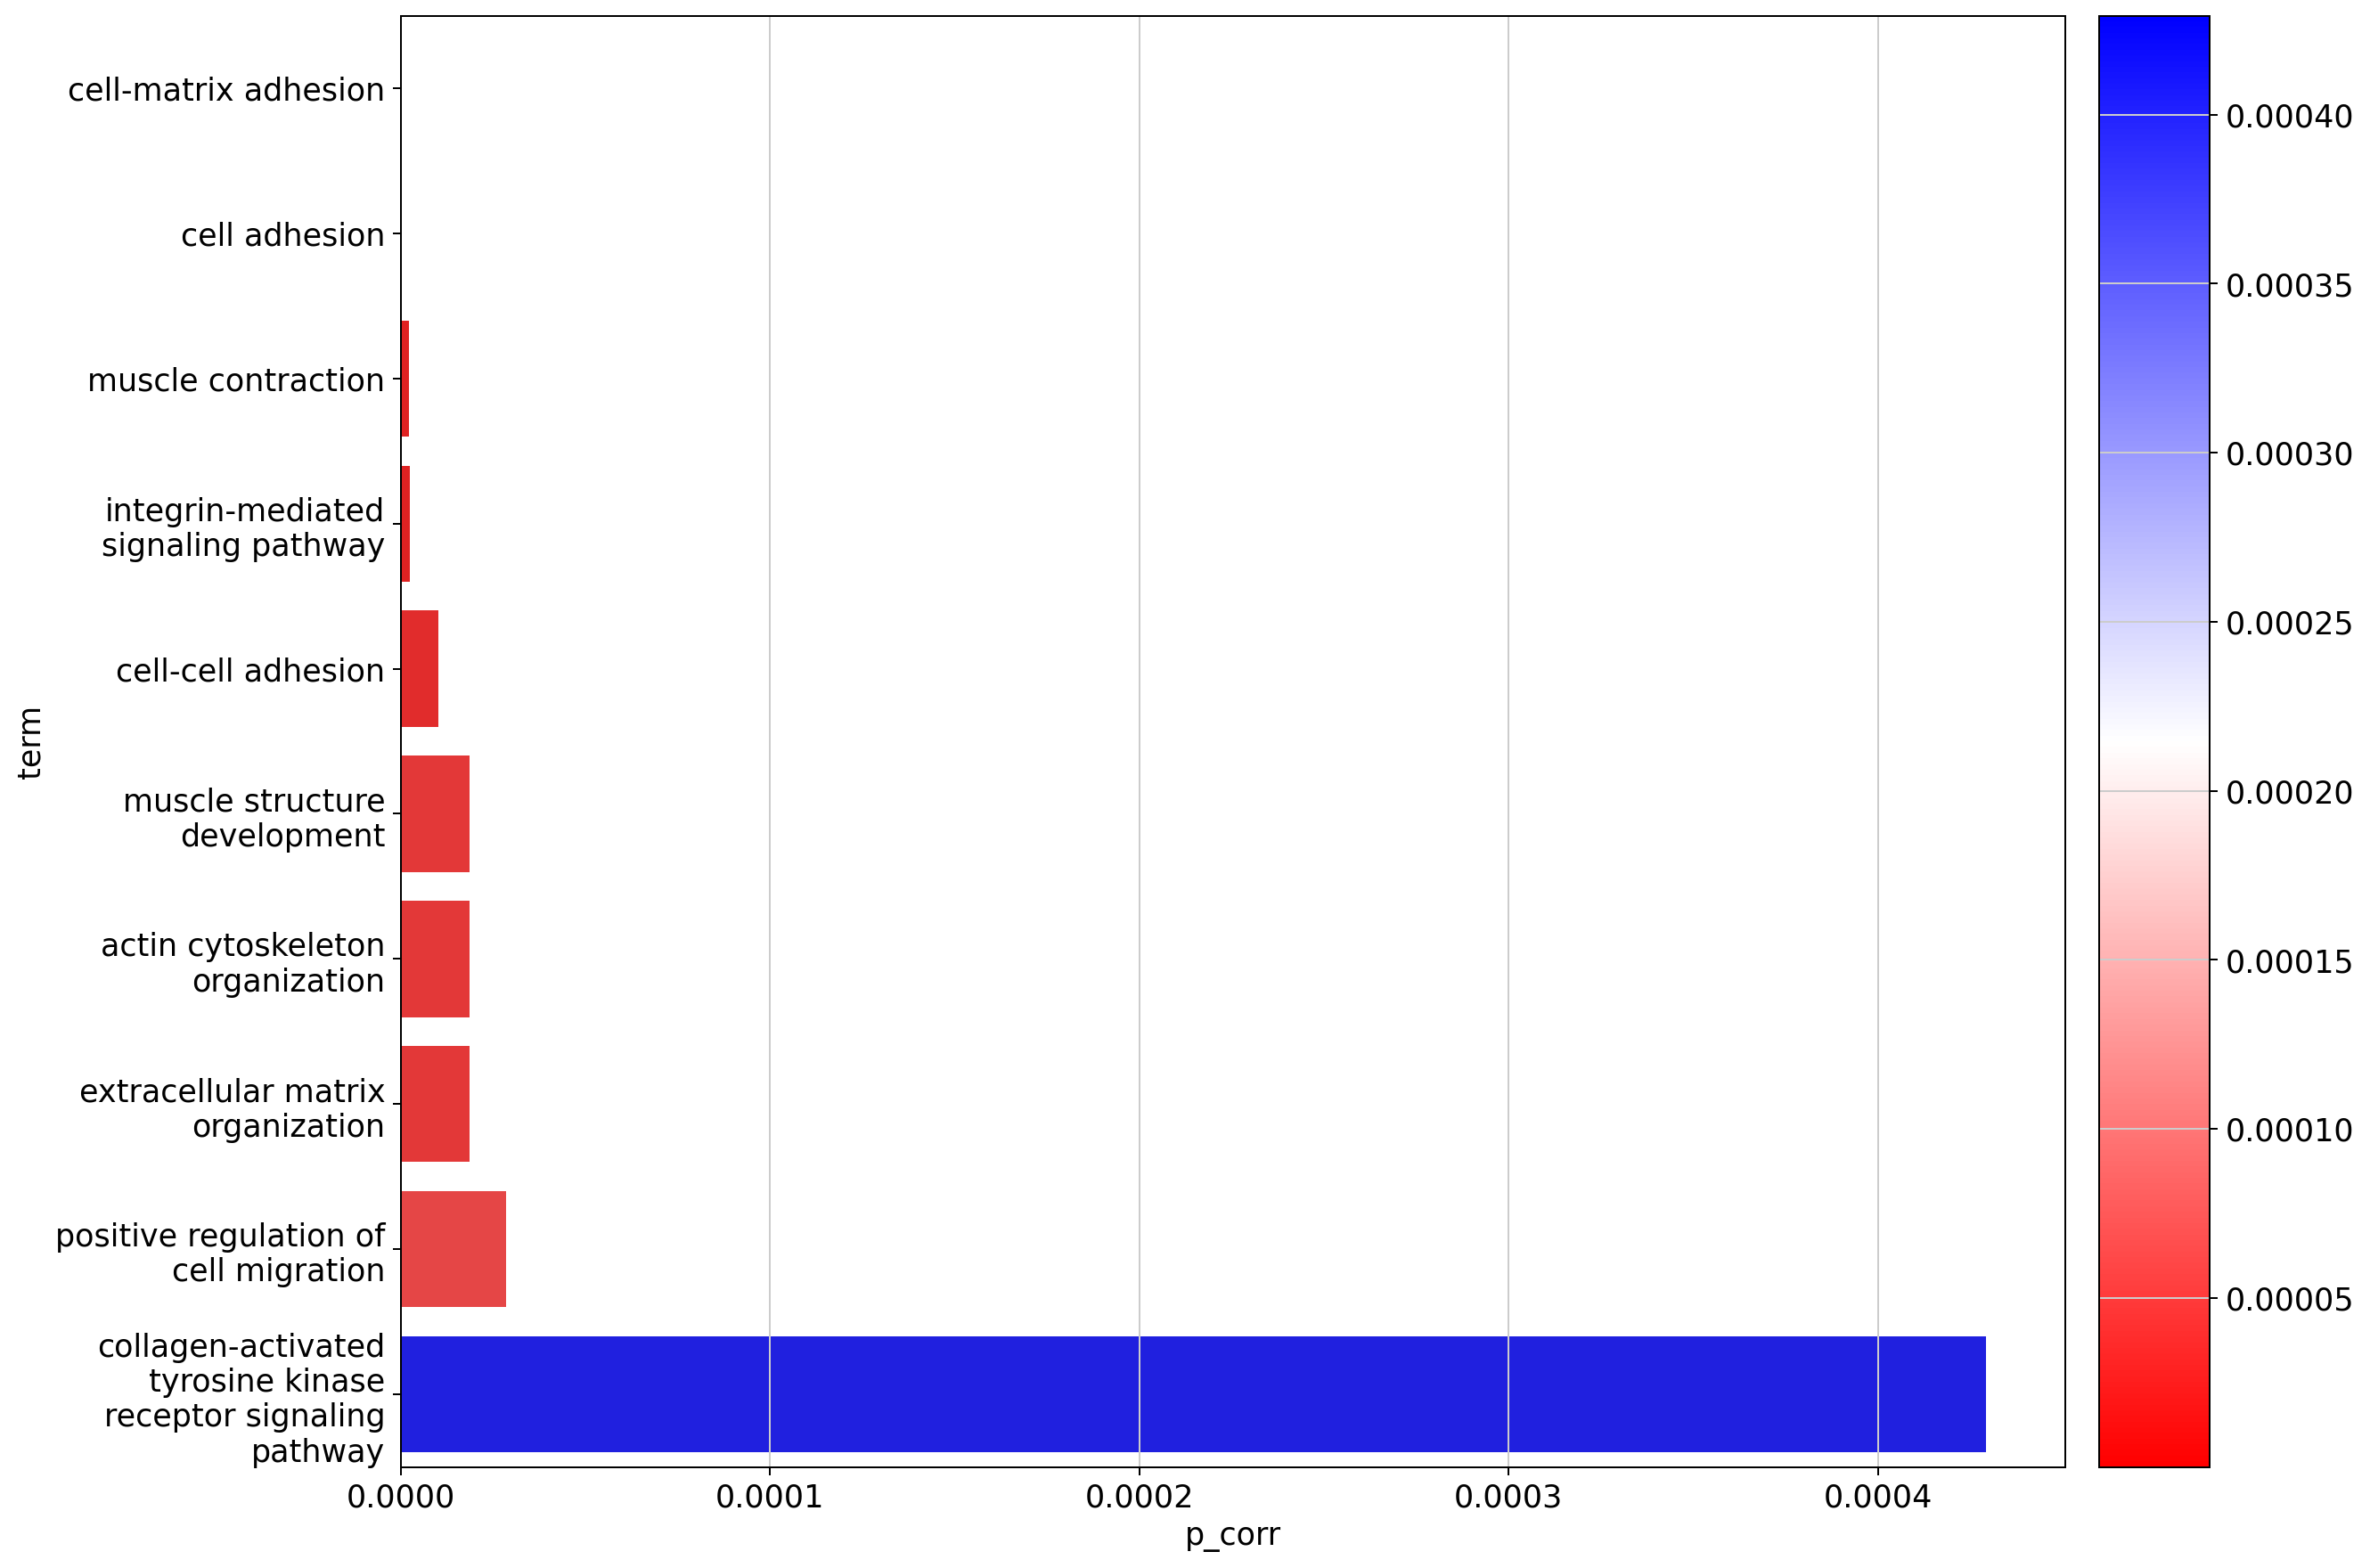

In [27]:
df_10 = df_filtered[df_filtered['group'] == '18']

go_df = go_it(df_10.names.values)
go_df10 = go_df[0:10]

# Create a 1x2 grid
fig = plt.figure(figsize=(15, 10))

# Define the grid layout
gs = GridSpec(1, 2, width_ratios=[15, 1])

# Left plot
ax1 = plt.subplot(gs[0])
sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper1.to_rgba(go_df10.p_corr.values), ax=ax1)
ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df10['term']])


# Right plot (Colorbar)
ax2 = plt.subplot(gs[1])
cmap = mpl.cm.bwr_r
norm = mpl.colors.Normalize(vmin=go_df10.p_corr.min(), vmax=go_df10.p_corr.max())
mapper1 = cm.ScalarMappable(norm=norm, cmap=cm.bwr_r)
cbl = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')


plt.tight_layout()  # Adjust layout for better spacing
plt.show()

* Cluster 19

input genes: 365
mapped genes: 346

Runing BP Ontology Analysis: current study set of 346 IDs.
 95%    329 of    346 study items found in association
100%    346 of    346 study items found in population(20606)
Calculating 12,220 uncorrected p-values using fisher_scipy_stats
  12,220 terms are associated with 17,011 of 20,606 population items
   2,011 terms are associated with    329 of    346 study items
  METHOD fdr_bh:
      20 GO terms found significant (< 0.05=alpha) ( 20 enriched +   0 purified): statsmodels fdr_bh
     145 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 346 IDs.
 98%    338 of    346 study items found in association
100%    346 of    346 study items found in population(20606)
Calculating 1,800 uncorrected p-values using fisher_scipy_stats
   1,800 terms are associated with 18,138 of 20,606 population items
     349 terms are associated 

<ipython-input-28-e27ec30822bc>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper1.to_rgba(go_df10.p_corr.values), ax=ax1)
<ipython-input-28-e27ec30822bc>:14: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper1.to_rgba(go_df10.p_corr.values), ax=ax1)
<ipython-input-28-e27ec30822bc>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df10['term']])


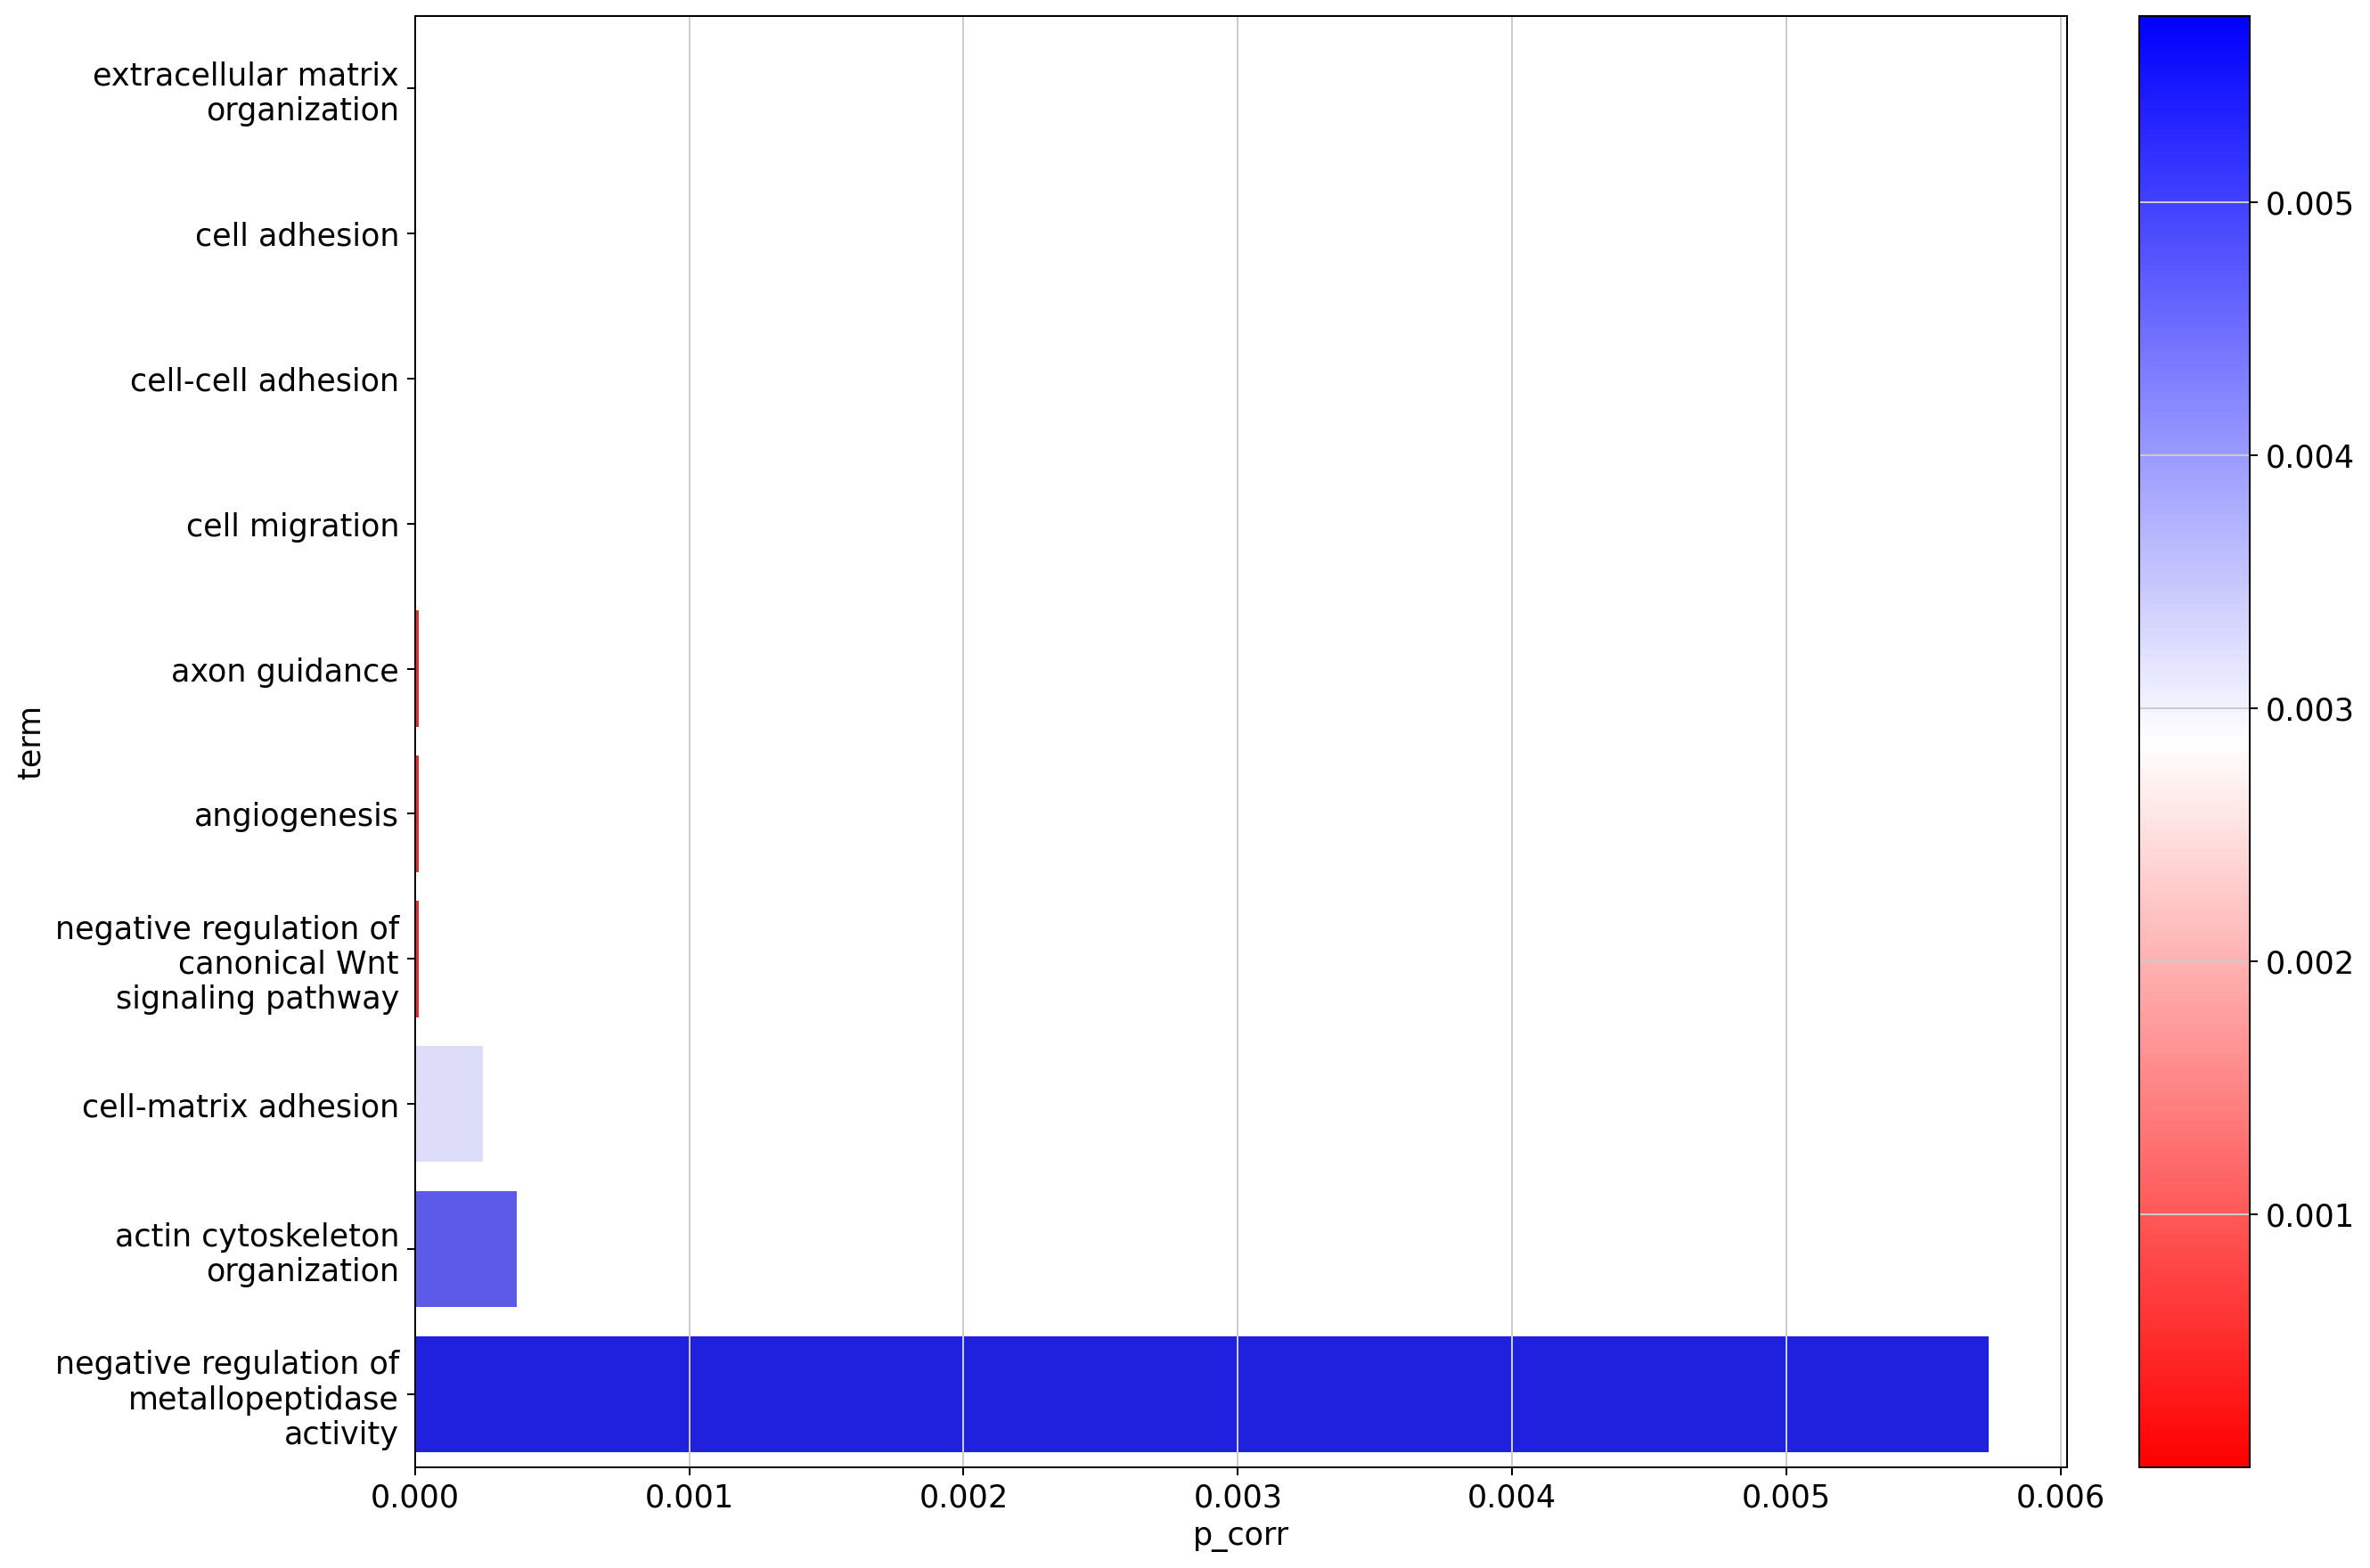

In [28]:
df_19 = df_filtered[df_filtered['group'] == '19']

go_df = go_it(df_19.names.values)
go_df10 = go_df[0:10]

# Create a 1x2 grid
fig = plt.figure(figsize=(15, 10))

# Define the grid layout
gs = GridSpec(1, 2, width_ratios=[15, 1])

# Left plot
ax1 = plt.subplot(gs[0])
sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper1.to_rgba(go_df10.p_corr.values), ax=ax1)
ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df10['term']])


# Right plot (Colorbar)
ax2 = plt.subplot(gs[1])
cmap = mpl.cm.bwr_r
norm = mpl.colors.Normalize(vmin=go_df10.p_corr.min(), vmax=go_df10.p_corr.max())
mapper1 = cm.ScalarMappable(norm=norm, cmap=cm.bwr_r)
cbl = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')


plt.tight_layout()  # Adjust layout for better spacing
plt.show()

* Cluster 2

input genes: 1532
mapped genes: 1381

Runing BP Ontology Analysis: current study set of 1381 IDs.
 93%  1,281 of  1,381 study items found in association
100%  1,381 of  1,381 study items found in population(20606)
Calculating 12,220 uncorrected p-values using fisher_scipy_stats
  12,220 terms are associated with 17,011 of 20,606 population items
   4,754 terms are associated with  1,281 of  1,381 study items
  METHOD fdr_bh:
     249 GO terms found significant (< 0.05=alpha) (244 enriched +   5 purified): statsmodels fdr_bh
     878 study items associated with significant GO IDs (enriched)
       3 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 1381 IDs.
 97%  1,343 of  1,381 study items found in association
100%  1,381 of  1,381 study items found in population(20606)
Calculating 1,800 uncorrected p-values using fisher_scipy_stats
   1,800 terms are associated with 18,138 of 20,606 population items
     643 terms are associa

<ipython-input-29-020346342a80>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper1.to_rgba(go_df10.p_corr.values), ax=ax1)
<ipython-input-29-020346342a80>:14: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper1.to_rgba(go_df10.p_corr.values), ax=ax1)
<ipython-input-29-020346342a80>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df10['term']])


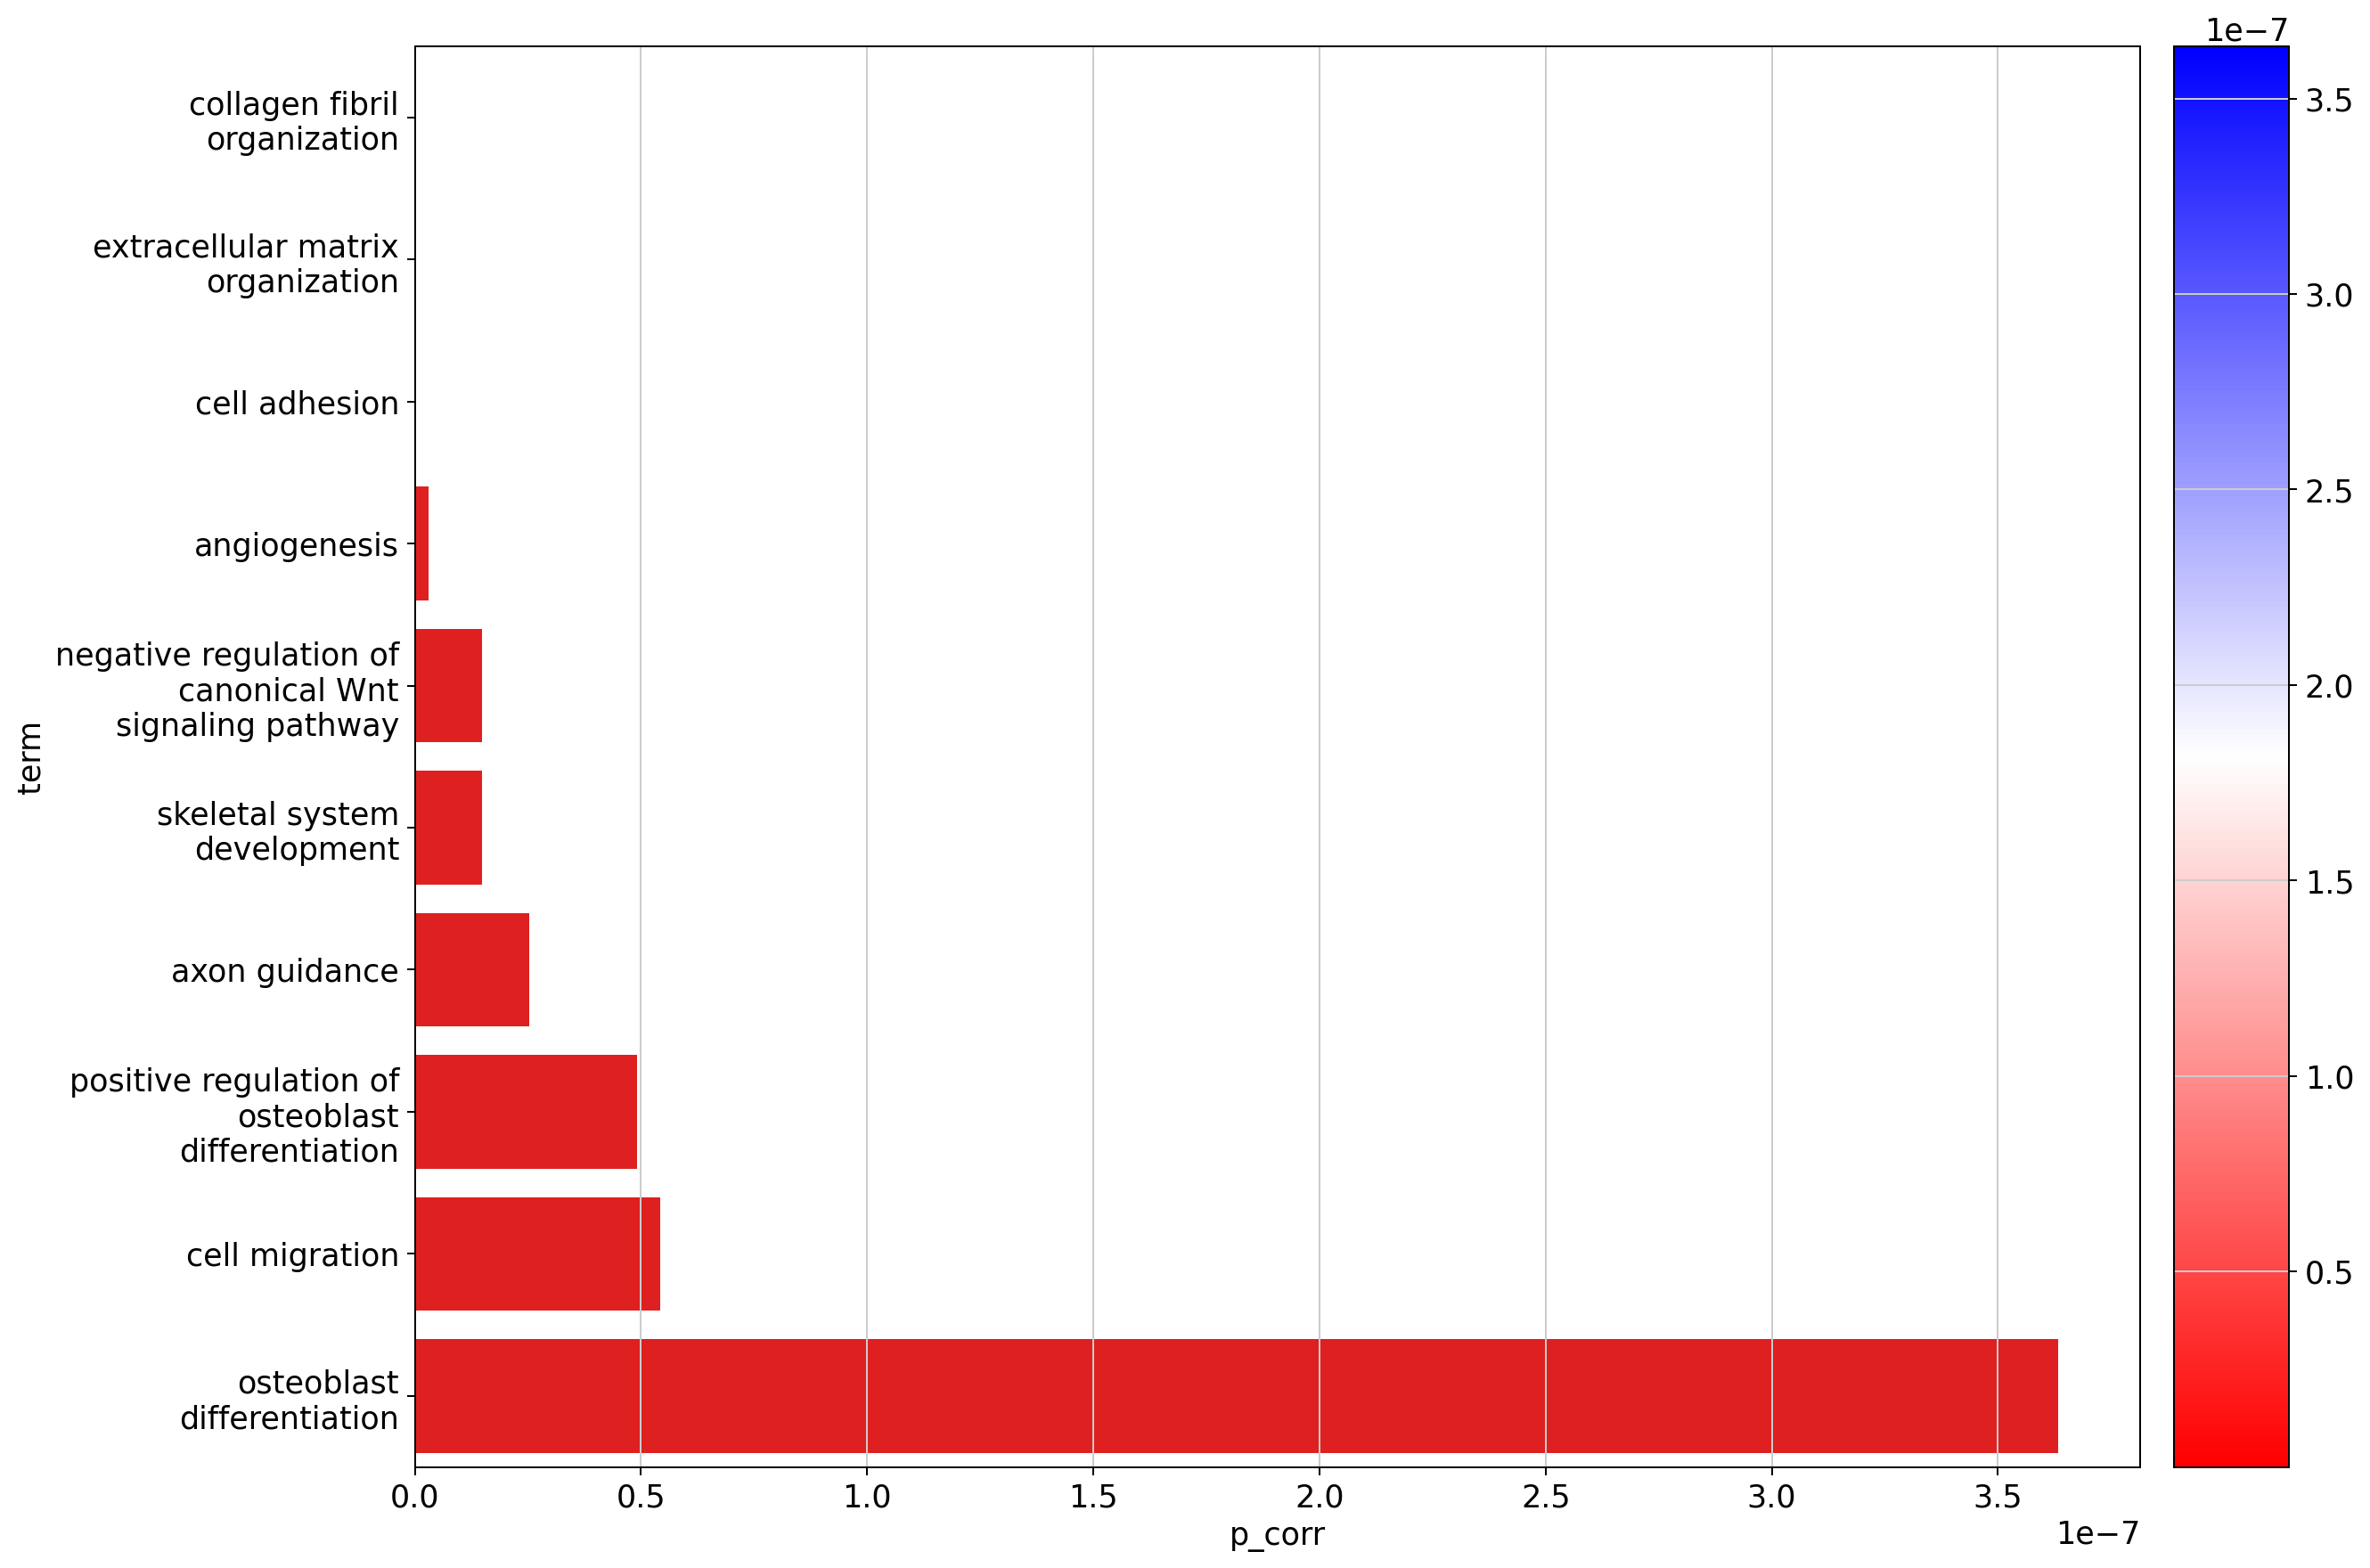

In [29]:
df_19 = df_filtered[df_filtered['group'] == '2']

go_df = go_it(df_19.names.values)
go_df10 = go_df[0:10]

# Create a 1x2 grid
fig = plt.figure(figsize=(15, 10))

# Define the grid layout
gs = GridSpec(1, 2, width_ratios=[15, 1])

# Left plot
ax1 = plt.subplot(gs[0])
sns.barplot(data=go_df10, x='p_corr', y='term', palette=mapper1.to_rgba(go_df10.p_corr.values), ax=ax1)
ax1.set_yticklabels([textwrap.fill(e, 22) for e in go_df10['term']])


# Right plot (Colorbar)
ax2 = plt.subplot(gs[1])
cmap = mpl.cm.bwr_r
norm = mpl.colors.Normalize(vmin=go_df10.p_corr.min(), vmax=go_df10.p_corr.max())
mapper1 = cm.ScalarMappable(norm=norm, cmap=cm.bwr_r)
cbl = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')


plt.tight_layout()  # Adjust layout for better spacing
plt.show()